In [66]:
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path
from scipy.signal import resample
from collections import namedtuple


from datetime import datetime, date
import re

# Updating making binned_FR files


In [7]:
data = pd.read_csv("/Users/AdamHarris/Desktop/drive-download-20250122T174732Z-001/bp01-2024-03-15-144724.tsv", sep='\t')

In [8]:
data

,time,type,subtype,content
0,0.000,info,experiment_name,Adam\ABCD_mEC_open_field
1,0.000,info,task_name,Peter\7x7open_field
2,0.000,info,task_file_hash,2633371478
3,0.000,info,setup_id,Big maze
4,0.000,info,framework_version,2.0.1
...,...,...,...,...
350,1788.100,event,sync,rsync
351,1791.942,event,sync,rsync
352,1800.000,event,timer,session_timer
353,1800.000,variable,run_end,"{""session_duration"": 30}"


In [ ]:
import json
import numpy as np
import pandas as pd
import os

def load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv):
    """
    Load cluster labels from cluster_group.tsv and cluster_KSlabel.tsv,
    returning a dictionary: { cluster_id: label }.
    
    The priority is:
      - cluster_group.tsv if available
      - fallback to cluster_KSlabel.tsv if the cluster is missing or 'unsorted' in the first
    """
    # Read cluster_group.tsv if it exists
    if os.path.exists(cluster_group_tsv):
        df_group = pd.read_csv(cluster_group_tsv, sep='\t')
        df_group.columns = ['cluster_id', 'group']  # Usually: cluster_id, group
    else:
        df_group = pd.DataFrame(columns=['cluster_id', 'group'])
    
    # Read cluster_KSlabel.tsv if it exists
    if os.path.exists(cluster_kslabel_tsv):
        df_ks = pd.read_csv(cluster_kslabel_tsv, sep='\t')
        df_ks.columns = ['cluster_id', 'KSlabel']  # Usually: cluster_id, KSlabel
    else:
        df_ks = pd.DataFrame(columns=['cluster_id', 'KSlabel'])
    
    # Convert cluster_id to int in both for easier merges
    df_group['cluster_id'] = df_group['cluster_id'].astype(int, errors='ignore')
    df_ks['cluster_id']    = df_ks['cluster_id'].astype(int, errors='ignore')
    
    # Merge them into a single DataFrame, outer join so we keep all
    df_merge = pd.merge(df_group, df_ks, on='cluster_id', how='outer')
    
    # Create a dictionary mapping cluster_id -> final label
    # We consider 'group' as the primary label if present, else use 'KSlabel'
    cluster_label_dict = {}
    for idx, row in df_merge.iterrows():
        cluster_id = int(row['cluster_id'])
        
        group_label = row['group'] if 'group' in row and pd.notnull(row['group']) else None
        ks_label    = row['KSlabel'] if 'KSlabel' in row and pd.notnull(row['KSlabel']) else None
        
        # Priority: if group_label is available (e.g. "good", "mua", etc.), use it, else use ks_label
        if group_label is not None:
            cluster_label_dict[cluster_id] = group_label
        else:
            cluster_label_dict[cluster_id] = ks_label
    
    return cluster_label_dict

def get_good_clusters(cluster_label_dict):
    """
    Return a sorted list of cluster IDs considered 'good'.
    This function can be adapted depending on how you define 'good' or 'SU'.
    """
    good = []
    for clust_id, label in cluster_label_dict.items():
        # Some Kilosort pipelines use 'good' or 'single' or 'SU'. Adjust as appropriate.
        if label in ['good', 'Good', 'su', 'SU']:
            good.append(clust_id)
    return sorted(good)

def bin_spikes(spike_times, spike_clusters, good_clusters, bin_size_ms=25, session_offset=0, session_duration_ms=None):
    """
    For a set of spikes that fall within [session_offset, session_offset+session_duration_ms),
    shift them to start at 0 and bin them at bin_size_ms. Return a 2D array: (n_clusters x n_time_bins).
    
    - spike_times: 1D array of spike times (ms).
    - spike_clusters: 1D array of cluster IDs for each spike_time.
    - good_clusters: list of cluster IDs that are 'good'.
    - bin_size_ms: size of each bin in ms.
    - session_offset: start time of session in ms within the concatenated data.
    - session_duration_ms: total duration of this session in ms.
    """
    # Identify the spikes for this session
    t_start = session_offset
    t_end   = session_offset + session_duration_ms
    
    # Boolean mask for spikes in this session
    in_session_mask = (spike_times >= t_start) & (spike_times < t_end)
    
    # Subset spike times & clusters
    sess_spike_times    = spike_times[in_session_mask] - t_start  # shift to 0-based
    sess_spike_clusters = spike_clusters[in_session_mask]
    
    # Figure out how many bins we need
    n_bins = int(np.ceil(session_duration_ms / bin_size_ms))
    
    # We'll create a 2D array: shape = (len(good_clusters), n_bins)
    spike_matrix = np.zeros((len(good_clusters), n_bins), dtype=np.int32)
    
    # Make a quick index from cluster_id -> row index in spike_matrix
    cluster_index_map = {clust_id: i for i, clust_id in enumerate(good_clusters)}
    
    # Digitize times to bin indices
    bin_indices = (sess_spike_times // bin_size_ms).astype(int)
    
    # Accumulate counts
    for t_bin, clust in zip(bin_indices, sess_spike_clusters):
        if clust in cluster_index_map:
            # increment the corresponding cluster row, bin column
            spike_matrix[cluster_index_map[clust], t_bin] += 1
    
    return spike_matrix

def main():
    # -------------------------------------------------------------------------
    # 1) Load the JSON file containing session file sizes in bytes
    # -------------------------------------------------------------------------
    json_path = '/path/to/session_sizes.json'
    with open(json_path, 'r') as f:
        session_dict = json.load(f)
    # session_dict: { file_path: file_size_in_bytes, ... }

    # Sort the sessions by file_path or, if you prefer, by recording time
    # (In your example, the keys appear in chronological order, but let's force a sorted list anyway.)
    session_items = sorted(session_dict.items(), key=lambda x: x[0])
    
    # -------------------------------------------------------------------------
    # 2) Compute session boundaries in ms
    # -------------------------------------------------------------------------
    bytes_per_sample = 768
    sampling_rate_hz = 30000
    # each second has 30000 samples, each sample is 768 bytes
    #  => 30000 samples per sec => 30000 * 768 bytes per second
    #  => 1 sample = 768 bytes => 1 ms = 30 samples
    session_boundaries = []
    cumulative_ms = 0.0
    
    session_info = []  # will hold (file_path, start_ms, end_ms)
    
    for (file_path, file_size) in session_items:
        # number of raw samples in this session
        n_samples = file_size / bytes_per_sample
        
        # convert to ms (1 second = 1000 ms -> 30000 samples => 1 ms = 30 samples)
        duration_ms = n_samples / 30.0  # because 30 samples per ms at 30 kHz
        start_ms = cumulative_ms
        end_ms   = cumulative_ms + duration_ms
        
        session_info.append((file_path, start_ms, end_ms))
        cumulative_ms = end_ms
    
    # -------------------------------------------------------------------------
    # 3) Load the Kilosort spike_times, spike_clusters
    # -------------------------------------------------------------------------
    kilosort_folder = '/path/to/kilosort_output'  # where spike_times.npy etc. reside
    
    spike_times = np.load(os.path.join(kilosort_folder, 'spike_times.npy'))  # confirm if truly in ms or samples
    spike_clusters = np.load(os.path.join(kilosort_folder, 'spike_clusters.npy'))
    
    # If your spike_times are actually in samples at 30 kHz, do:
    # spike_times = spike_times / 30.0  # to convert to ms
    # Adjust if needed to keep consistent with how your pipeline is set.
    
    # -------------------------------------------------------------------------
    # 4) Load cluster labels (cluster_group.tsv, cluster_KSlabel.tsv) & get "good" clusters
    # -------------------------------------------------------------------------
    cluster_group_tsv   = os.path.join(kilosort_folder, 'cluster_group.tsv')
    cluster_kslabel_tsv = os.path.join(kilosort_folder, 'cluster_KSlabel.tsv')
    cluster_labels = load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv)
    
    good_clusters = get_good_clusters(cluster_labels)
    print(f"Found {len(good_clusters)} 'good' clusters.")
    
    # -------------------------------------------------------------------------
    # 5) For each session, partition the spikes and bin into 25 ms bins
    # -------------------------------------------------------------------------
    bin_size_ms = 25
    session_spike_counts = []  # will hold one array for each session
    
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        duration_ms = end_ms - start_ms
        print(f"Session {i}: {file_path}")
        print(f"   start_ms = {start_ms:.2f}, end_ms = {end_ms:.2f}, duration_ms = {duration_ms:.2f}")
        
        # bin the spikes for this session
        spike_count_mat = bin_spikes(
            spike_times=spike_times,
            spike_clusters=spike_clusters,
            good_clusters=good_clusters,
            bin_size_ms=bin_size_ms,
            session_offset=start_ms,
            session_duration_ms=duration_ms
        )
        
        session_spike_counts.append(spike_count_mat)
    
    # session_spike_counts is now a list of arrays of shape [n_good_clusters, n_time_bins_for_that_session].
    # You can save them or keep them in memory for further analysis.
    
    # Example: store in a dictionary, then maybe save to npy or pickle
    results_dict = {}
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        results_dict[file_path] = session_spike_counts[i]
    
    # If you wish to save them individually:
    output_dir = '/path/to/output_matrices'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        # A nice name for the output file
        session_filename = os.path.basename(file_path)  # or parse the date/time from the path
        out_path = os.path.join(output_dir, f"binnedSpikes_session{i}.npy")
        np.save(out_path, session_spike_counts[i])
        print(f"Saved binned spikes for session {i} to {out_path}")
    
    print("All sessions processed and binned spike arrays saved.")

if __name__ == '__main__':
    main()


In [11]:
import json
import numpy as np
import pandas as pd
import os

def load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv):
    """
    Load cluster labels from cluster_group.tsv and cluster_KSlabel.tsv,
    returning a dictionary: { cluster_id: label }.
    """

    # Try to read with a header
    if os.path.exists(cluster_group_tsv):
        df_group = pd.read_csv(cluster_group_tsv, sep='\t')
        # If the file indeed has columns named something else, rename:
        # e.g. many labs have these columns: 'cluster_id', 'group'
        # If your file is correct, you can skip or adapt the rename logic below
        if list(df_group.columns) != ['cluster_id', 'group']:
            # Attempt a rename; adjust logic if your columns differ
            df_group.columns = ['cluster_id', 'group']
    else:
        df_group = pd.DataFrame(columns=['cluster_id', 'group'])
    
    if os.path.exists(cluster_kslabel_tsv):
        df_ks = pd.read_csv(cluster_kslabel_tsv, sep='\t')
        # e.g. columns might be 'cluster_id', 'KSlabel'
        if list(df_ks.columns) != ['cluster_id', 'KSlabel']:
            df_ks.columns = ['cluster_id', 'KSlabel']
    else:
        df_ks = pd.DataFrame(columns=['cluster_id', 'KSlabel'])
    
    # Ensure correct types
    df_group['cluster_id'] = df_group['cluster_id'].astype(int, errors='ignore')
    df_ks['cluster_id']    = df_ks['cluster_id'].astype(int, errors='ignore')
    
    # Merge
    df_merge = pd.merge(df_group, df_ks, on='cluster_id', how='outer')
    
    # Build the dictionary
    cluster_label_dict = {}
    for idx, row in df_merge.iterrows():
        clust_id = int(row['cluster_id'])
        
        # "group" could be "good", "mua", etc.
        group_label = row['group']   if 'group'   in row and pd.notnull(row['group'])   else None
        ks_label    = row['KSlabel'] if 'KSlabel' in row and pd.notnull(row['KSlabel']) else None
        
        # Priority: if group_label is available, use it, otherwise fallback to ks_label
        if group_label is not None:
            cluster_label_dict[clust_id] = group_label
        else:
            cluster_label_dict[clust_id] = ks_label
    
    return cluster_label_dict

    

def get_good_clusters(cluster_label_dict):
    """
    Return a sorted list of cluster IDs considered 'good'.
    This function can be adapted depending on how you define 'good' or 'SU'.
    """
    good = []
    for clust_id, label in cluster_label_dict.items():
        # Some Kilosort pipelines use 'good' or 'SU'; adjust as needed
        if label in ['good', 'Good', 'su', 'SU']:
            good.append(clust_id)
    return sorted(good)

def bin_spikes(spike_times, spike_clusters, good_clusters,
               bin_size_ms=25,
               session_offset=0,
               session_duration_ms=None):
    """
    For a set of spikes that fall within [session_offset, session_offset+session_duration_ms),
    shift them to start at 0 and bin them at bin_size_ms. Return a 2D array: (n_clusters x n_time_bins).
    
    - spike_times: 1D array of spike times (ms).
    - spike_clusters: 1D array of cluster IDs for each spike_time.
    - good_clusters: list of cluster IDs that are 'good'.
    - bin_size_ms: size of each bin in ms.
    - session_offset: start time of session in ms within the concatenated data.
    - session_duration_ms: total duration of this session in ms.
    """
    # Identify the spikes for this session
    t_start = session_offset
    t_end   = session_offset + session_duration_ms
    
    # Boolean mask for spikes in this session
    in_session_mask = (spike_times >= t_start) & (spike_times < t_end)
    
    # Subset spike times & clusters
    sess_spike_times    = spike_times[in_session_mask] - t_start  # shift to 0-based
    sess_spike_clusters = spike_clusters[in_session_mask]
    
    # Figure out how many bins we need
    n_bins = int(np.ceil(session_duration_ms / bin_size_ms))
    
    # We'll create a 2D array: shape = (len(good_clusters), n_bins)
    spike_matrix = np.zeros((len(good_clusters), n_bins), dtype=np.int32)
    
    # Make a quick index from cluster_id -> row index in spike_matrix
    cluster_index_map = {clust_id: i for i, clust_id in enumerate(good_clusters)}
    
    # Digitize times to bin indices
    bin_indices = (sess_spike_times // bin_size_ms).astype(int)
    
    # Accumulate counts
    for t_bin, clust in zip(bin_indices, sess_spike_clusters):
        if clust in cluster_index_map:
            spike_matrix[cluster_index_map[clust], t_bin] += 1
    
    return spike_matrix

def main():


    kilosort_folder = "/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all"
    json__path =os.path.join(kilosort_folder, [i for i in os.listdir(kilosort_folder) if i.endswith('.json')][0])
    # -------------------------------------------------------------------------
    # 1) Load the JSON file containing session file sizes in bytes
    # -------------------------------------------------------------------------
    # json_path = '/path/to/session_sizes.json'
    with open(json_path, 'r') as f:
        session_dict = json.load(f)
    # session_dict: { file_path: file_size_in_bytes, ... }

    # Sort the sessions by file_path or, if you prefer, by recording time
    session_items = sorted(session_dict.items(), key=lambda x: x[0])
    
    # -------------------------------------------------------------------------
    # 2) Compute session boundaries in ms
    # -------------------------------------------------------------------------
    bytes_per_sample = 768
    sampling_rate_hz = 30000
    # each second has 30000 samples, each sample is 768 bytes
    # => 1 sample = 768 bytes => 1 second = 30000 samples => 30000 * 768 bytes
    
    session_info = []
    cumulative_ms = 0.0
    
    for (file_path, file_size) in session_items:
        # number of raw samples in this session
        n_samples = file_size / bytes_per_sample
        
        # convert to ms (1 second = 1000 ms -> 30000 samples => 1 ms = 30 samples)
        duration_ms = n_samples / 30.0  # 30 samples per ms
        start_ms = cumulative_ms
        end_ms   = cumulative_ms + duration_ms
        
        session_info.append((file_path, start_ms, end_ms))
        cumulative_ms = end_ms
    
    # -------------------------------------------------------------------------
    # 3) Load the Kilosort spike_times, spike_clusters
    #    Convert spike_times from samples to ms
    # -------------------------------------------------------------------------
    
    spike_times_samples = np.load(os.path.join(kilosort_folder, 'spike_times.npy'))
    spike_clusters = np.load(os.path.join(kilosort_folder, 'spike_clusters.npy'))
    
    # Convert from samples to ms, since each sample = 1/30000 sec = 0.0333... ms
    spike_times_ms = spike_times_samples / 30.0
    
    # -------------------------------------------------------------------------
    # 4) Load cluster labels (cluster_group.tsv, cluster_KSlabel.tsv) & get "good" clusters
    # -------------------------------------------------------------------------
    cluster_group_tsv   = os.path.join(kilosort_folder, 'cluster_group.tsv')
    cluster_kslabel_tsv = os.path.join(kilosort_folder, 'cluster_KSlabel.tsv')
    cluster_labels = load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv)
    
    good_clusters = get_good_clusters(cluster_labels)
    print(f"Found {len(good_clusters)} 'good' clusters.")
    
    # -------------------------------------------------------------------------
    # 5) For each session, partition the spikes and bin into 25 ms bins
    # -------------------------------------------------------------------------
    bin_size_ms = 25
    session_spike_counts = []  # will hold one array for each session
    
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        duration_ms = end_ms - start_ms
        print(f"Session {i}: {file_path}")
        print(f"   start_ms = {start_ms:.2f}, end_ms = {end_ms:.2f}, duration_ms = {duration_ms:.2f}")
        
        # bin the spikes for this session
        spike_count_mat = bin_spikes(
            spike_times=spike_times_ms,
            spike_clusters=spike_clusters,
            good_clusters=good_clusters,
            bin_size_ms=bin_size_ms,
            session_offset=start_ms,
            session_duration_ms=duration_ms
        )
        
        session_spike_counts.append(spike_count_mat)
    
    # session_spike_counts is now a list of arrays of shape [n_good_clusters, n_time_bins_for_that_session].
    # You can save them or keep them in memory for further analysis.
    
    # Example: store in a dictionary, then maybe save to npy or pickle
    results_dict = {}
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        results_dict[file_path] = session_spike_counts[i]
    
    # If you wish to save them individually:
    output_dir = '/Users/AdamHarris/Desktop/test_output_mats'
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (file_path, start_ms, end_ms) in enumerate(session_info):
        # A nice name for the output file
        session_filename = os.path.basename(file_path)  # or parse the date/time from the path
        out_path = os.path.join(output_dir, f"binnedSpikes_session{i}.npy")
        np.save(out_path, session_spike_counts[i])
        print(f"Saved binned spikes for session {i} to {out_path}")
    
    print("All sessions processed and binned spike arrays saved.")

if __name__ == '__main__':
    main()


Found 27 'good' clusters.
Session 0: /ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_12-59-35/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat
   start_ms = 0.00, end_ms = 1219909.20, duration_ms = 1219909.20


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def load_metadata(cohort, mouse, data_folder):
    data_directory = f"{data_folder}/cohort{cohort}/"       Data_folderx+'/cohort'+str(cohort)+'/'#+mouse[:4]+'/'
    MetaDatafile_path= f"{data_directory}/MetaData.xlsx - {mouse}.csv"
    
    with open(MetaDatafile_path, 'r') as f:
        MetaData = np.genfromtxt(f, delimiter=',',dtype=str, usecols=np.arange(0,18))
    MetaData_structure=MetaData[0]
    Include_mask=MetaData[1:,np.where(MetaData[0]=='Include')[0][0]]=='1' ##added 06/07/2021
    for indx, variable in enumerate(MetaData_structure):
        if variable != 'Weight_pre':
            Variable_dic[mouse][variable]=np.asarray(remove_empty(MetaData[1:,indx][Include_mask]))
        else:
            Variable_dic[mouse][variable]=MetaData[1:,indx][Include_mask]

    
    return metadata

In [ ]:
import json
import numpy as np
import pandas as pd
import os

def load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv):
    """
    Load cluster labels from cluster_group.tsv and cluster_KSlabel.tsv,
    returning a dictionary: { cluster_id: label }.
    
    The priority is:
      - cluster_group.tsv (if present)
      - fallback to cluster_KSlabel.tsv (if the cluster is missing a label in the first)
    """
    # cluster_group file
    if os.path.exists(cluster_group_tsv):
        df_group = pd.read_csv(cluster_group_tsv, sep='\t')
        # If needed, rename columns if they don't match exactly:
        if 'cluster_id' not in df_group.columns or 'group' not in df_group.columns:
            df_group.columns = ['cluster_id', 'group']
    else:
        df_group = pd.DataFrame(columns=['cluster_id', 'group'])
    
    # cluster_KSlabel file
    if os.path.exists(cluster_kslabel_tsv):
        df_ks = pd.read_csv(cluster_kslabel_tsv, sep='\t')
        if 'cluster_id' not in df_ks.columns or 'KSlabel' not in df_ks.columns:
            df_ks.columns = ['cluster_id', 'KSlabel']
    else:
        df_ks = pd.DataFrame(columns=['cluster_id', 'KSlabel'])
    
    # Convert cluster_id to int in both for easier merges
    df_group['cluster_id'] = df_group['cluster_id'].astype(int, errors='ignore')
    df_ks['cluster_id']    = df_ks['cluster_id'].astype(int, errors='ignore')
    
    # Merge them into a single DataFrame, outer join so we keep all
    df_merge = pd.merge(df_group, df_ks, on='cluster_id', how='outer')
    
    # Create a dictionary mapping cluster_id -> final label
    cluster_label_dict = {}
    for idx, row in df_merge.iterrows():
        clust_id = int(row['cluster_id'])
        
        group_label = None
        ks_label    = None
        
        if 'group' in row and pd.notnull(row['group']):
            group_label = row['group']
        if 'KSlabel' in row and pd.notnull(row['KSlabel']):
            ks_label = row['KSlabel']
        
        # Priority: if group_label is available, use it; otherwise fallback to ks_label
        final_label = group_label if group_label is not None else ks_label
        cluster_label_dict[clust_id] = final_label
    
    return cluster_label_dict

def get_good_clusters(cluster_label_dict):
    """
    Return a sorted list of cluster IDs considered 'good'.
    Adjust the condition below for your labeling convention:
    e.g. 'good', 'Good', 'su', 'SU'
    """
    good = []
    for clust_id, label in cluster_label_dict.items():
        if label in ['good', 'Good', 'su', 'SU']:
            good.append(clust_id)
    return sorted(good)

def bin_spikes(spike_times_ms, spike_clusters, good_clusters,
               bin_size_ms=25,
               session_offset=0,
               session_duration_ms=None):
    """
    Bin 'good' clusters' spikes into 25 ms bins for one session.

    - spike_times_ms: 1D array of spike times (ms, in concatenated timeline).
    - spike_clusters: 1D array of cluster IDs for each spike_time.
    - good_clusters: list of cluster IDs that are 'good'.
    - bin_size_ms: size of each bin in ms (default = 25 ms).
    - session_offset: the starting time (ms) of this session in the *concatenated* timeline.
    - session_duration_ms: total duration of this session from that offset.
    
    Returns a 2D array of shape (n_good_clusters, n_time_bins).
    """
    if session_duration_ms <= 0:
        # If there's no valid time range, return an empty matrix
        return np.zeros((len(good_clusters), 0), dtype=np.int32)
    
    t_start = session_offset
    t_end   = session_offset + session_duration_ms
    
    # Boolean mask for spikes in [t_start, t_end)
    in_session_mask = (spike_times_ms >= t_start) & (spike_times_ms < t_end)
    
    # Subset spike times & clusters
    # (Make sure these arrays are 1D with .squeeze())
    sess_spike_times    = spike_times_ms[in_session_mask].squeeze() - t_start
    sess_spike_clusters = spike_clusters[in_session_mask].squeeze()
    
    # Figure out how many bins we need
    n_bins = int(np.ceil(session_duration_ms / bin_size_ms))
    
    # We'll create a 2D array: shape = (len(good_clusters), n_bins)
    spike_matrix = np.zeros((len(good_clusters), n_bins), dtype=np.int32)
    
    # Make a quick index from cluster_id -> row index in spike_matrix
    cluster_index_map = {clust_id: i for i, clust_id in enumerate(good_clusters)}
    
    # Digitize times to bin indices
    bin_indices = (sess_spike_times // bin_size_ms).astype(int)
    
    # Accumulate counts in each bin
    for t_bin, clust in zip(bin_indices, sess_spike_clusters):
        if 0 <= t_bin < n_bins:  # just a safety check
            if clust in cluster_index_map:
                spike_matrix[cluster_index_map[clust], t_bin] += 1
    
    return spike_matrix

def main():
    # -------------------------------------------------------------------------
    # 1) Load the JSON file containing session file sizes in bytes
    # -------------------------------------------------------------------------
    kilosort_folder = "/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all"
    json_path =os.path.join(kilosort_folder, [i for i in os.listdir(kilosort_folder) if i.endswith('.json')][0])
    print(json_path)

    with open(json_path, 'r') as f:
        session_dict = json.load(f)

    print(session_dict)
    # session_dict: { file_path: file_size_in_bytes, ... }
    # e.g. "/path/to/2024-03-21_12-59-35/continuous.dat": 28106707968
    
    # Sort the sessions by file_path or by date/time—adjust to your preference
    session_items = sorted(session_dict.items(), key=lambda x: x[0])
    
    # -------------------------------------------------------------------------
    # 2) Compute absolute session boundaries in the concatenated timeline (ms)
    # -------------------------------------------------------------------------
    bytes_per_sample = 768
    sampling_rate_hz = 30000  # 30 kHz
    # => each sample = 768 bytes
    # => 1 ms corresponds to 30 samples at 30 kHz
    
    session_info = []  # will hold (file_path, start_ms, end_ms) in the *concatenated* timeline
    cumulative_ms = 0.0
    
    for (file_path, file_size) in session_items:
        # number of raw samples in this session
        n_samples = file_size / bytes_per_sample
        
        # convert to ms:  n_samples / 30  (since 30 samples = 1 ms)
        duration_ms = n_samples / 30.0
        start_ms = cumulative_ms
        end_ms   = cumulative_ms + duration_ms
        
        session_info.append((file_path, start_ms, end_ms))
        cumulative_ms = end_ms
    
    # -------------------------------------------------------------------------
    # 3) Load spike_times and spike_clusters from Kilosort output
    #    Convert from sample indices (30 kHz) to ms
    # -------------------------------------------------------------------------

    
    spike_times_samples = np.load(os.path.join(kilosort_folder, 'spike_times.npy'))
    spike_clusters      = np.load(os.path.join(kilosort_folder, 'spike_clusters.npy'))
    
    # Make sure they are both squeezed to 1D
    spike_times_samples = spike_times_samples.squeeze()
    spike_clusters      = spike_clusters.squeeze()
    
    # Convert from samples to ms
    spike_times_ms = spike_times_samples / 30.0
    
    # -------------------------------------------------------------------------
    # 4) Load cluster labels from TSVs & choose 'good' clusters
    # -------------------------------------------------------------------------
    cluster_group_tsv   = os.path.join(kilosort_folder, 'cluster_group.tsv')
    cluster_kslabel_tsv = os.path.join(kilosort_folder, 'cluster_KSlabel.tsv')
    cluster_labels = load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv)
    
    good_clusters = get_good_clusters(cluster_labels)
    print(f"Found {len(good_clusters)} 'good' clusters.")
    
    # -------------------------------------------------------------------------
    # 5) For each session, load sample_numbers.npy to find the first sync pulse,
    #    then truncate everything prior to that pulse for binning.
    # -------------------------------------------------------------------------
    bin_size_ms = 25
    session_spike_counts = []  # will hold one array per session
    
    for i, (file_path, session_abs_start, session_abs_end) in enumerate(session_info):
        # The absolute session boundaries in the concatenated timeline are
        #  [session_abs_start, session_abs_end).
        file_path_volumes = file_path.replace('/ceph/', '/Volumes/')
        session_dir = os.path.dirname(file_path_volumes)
        sync_file   = os.path.join(session_dir, 'sample_numbers.npy')
        print(sync_file)
        
        if not os.path.exists(sync_file):
            print(f"Warning: sync_file not found for {file_path}. Skipping first-sync truncation.")
            # We'll treat the entire session from session_abs_start to session_abs_end
            # i.e. no extra offset.
            first_sync_ms = 0.0
        else:
            # Load the sample_numbers array
            sample_numbers = np.load(sync_file).squeeze()
            # Typically it's 1D. We'll assume the first sync pulse is sample_numbers[0].
            first_sync_sample = sample_numbers[0]
            # Convert that to ms
            first_sync_ms = first_sync_sample / 30.0
        
        # Now we want to shift the session's start forward by first_sync_ms
        # So that time=0 in our local bins corresponds to the first sync pulse
        new_session_start = session_abs_start + first_sync_ms
        new_session_duration = session_abs_end - new_session_start
        
        # Bin the spikes for this truncated session
        spike_count_mat = bin_spikes(
            spike_times_ms=spike_times_ms,
            spike_clusters=spike_clusters,
            good_clusters=good_clusters,
            bin_size_ms=bin_size_ms,
            session_offset=new_session_start,
            session_duration_ms=new_session_duration
        )
        
        session_spike_counts.append(spike_count_mat)
        
        print(f"Session {i}: {file_path}")
        print(f"   Original: start_ms={session_abs_start:.2f}, end_ms={session_abs_end:.2f}")
        print(f"   First sync pulse at {first_sync_sample} samples => {first_sync_ms:.2f} ms")
        print(f"   Final binning range: [{new_session_start:.2f}, {new_session_start + new_session_duration:.2f}) ms")
        print(f"   Output shape: {spike_count_mat.shape}\n")
    
    # -------------------------------------------------------------------------
    # 6) Save each session’s 2D spike count matrix
    # -------------------------------------------------------------------------
    output_dir = '/Users/AdamHarris/Desktop/test_output_mats'
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (file_path, _, _) in enumerate(session_info):
        out_name = f"binnedSpikes_session{i}.npy"
        out_path = os.path.join(output_dir, out_name)
        np.save(out_path, session_spike_counts[i])
        print(f"Saved binned spikes for session {i} -> {out_path}")
    
    print("All sessions processed and binned spike arrays saved.")

if __name__ == '__main__':
    main()


/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all/bp01_28032024_31032024_02042024_20241213162222_ALL_20241213162222.json
{'/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_12-59-35/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28106707968, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_13-23-31/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28535519232, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_13-48-00/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28141166592, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_14-12-33/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 27900291072, '/ceph/behrens/adam_h

KeyboardInterrupt: 

In [32]:
metadata_path = r'/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/MetaData.xlsx - bp01_sleep.csv'


In [56]:
def extract_cohort_and_mouse_id(filepath):
    """
    Extracts the cohort number and mouse ID from a given file path.
    Args:
        filepath (str): The file path from which to extract the cohort number and mouse ID.

    Returns:
        tuple: A tuple containing the cohort number (str) and mouse ID (str) if the pattern
               is found, otherwise (None, None).
    """
    match = re.search(r"cohort(\d+)/.*?/([^/]+)/", filepath)
    if match:
        cohort = match.group(1)  # Extract the cohort number
        mouse_id = match.group(2)  # Extract the mouse ID
        return cohort, mouse_id
    else:
        print('cannot retrieve mouse and cohort from filepath')
        return None, None


def load_json(json_path):
    
    with open(json_path, 'r') as f:
        session_dict = json.load(f)
    
    session_items = session_dict.items()

    return session_items
    

def load_metadata(cohort, mouse, data_folder):

    """
    Load metadata for a given mouse in a given cohort.
    Returns two DataFrames: one for awake, one for sleep.
    """
    data_directory = f"{data_folder}/cohort{cohort}/"   
    metadata_path= f"{data_directory}/MetaData.xlsx - {mouse}.csv"

    metadata_awake = pd.read_csv(metadata_path, delimiter=',',dtype=str)
    filtered_metadata_awake=metadata_awake[metadata_awake['Include']==1]
    
    try:
        metadata_path_sleep= f"{data_directory}/MetaData.xlsx - {mouse}_sleep.csv"
        metadata_sleep = pd.read_csv(metadata_path_sleep, delimiter=',',dtype=str)
        filtered_metadata_sleep=metadata_sleep[metadata_sleep['Include']==1]
        return filtered_metadata_awake, filtered_metadata_sleep

    except FileNotFoundError:
        print('No sleep metadata found for this mouse')
        return filtered_metadata_awake, None
    

def extract_ephys_date_time(filepath):
    """
    Extracts the date and time from a given file path using a regular expression.

    The function searches for a date-time pattern in the format 'YYYY-MM-DD_HH-MM-SS'
    within the provided file path. If a match is found, it returns the date and time
    as separate strings. If no match is found, it returns (None, None).

    Args:
        filepath (str): The file path containing the date-time information.

    Returns:
        tuple: A tuple containing the date and time as strings (date, time).
               If no match is found, returns (None, None).
    """
    # Regular expression to capture date-time format
    match = re.search(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})", filepath)
    if match:
        date = match.group(1)
        time = match.group(2)
        return date, time

    return None, None

def wake_or_sleep(ephys_filepath, metadata_awake, metadata_sleep):
    """
    Determines whether an electrophysiology (ephys) session is an awake or sleep session based on metadata.
    Args:
        ephys_filepath (str): The file path to the ephys data file.
        metadata_awake (pd.DataFrame): A DataFrame containing metadata for awake sessions.
        metadata_sleep (pd.DataFrame): A DataFrame containing metadata for sleep sessions.
    Returns:
        str: 'awake' if the session is an awake session, 'sleep' if the session is a sleep session, or None if the session is not found in either metadata.
    """

    sleep_status = None

    date, time = extract_ephys_date_time(ephys_filepath)
    
    # first try awake metadata

    filtered_awake =  metadata_awake[(metadata_awake["Date"] == date) & (metadata_awake["Ephys"] == time)]
    
    if len(filtered_awake>1):
        print('More than one awake entry found for this date and time')
    if len(filtered_awake==0):
        print('Not an awake session')
    if len(filtered_awake==1):
        print('awake session')
        sleep_status = 'awake'

    if sleep_status =='awake':
        return sleep_status
    
    else:
        # then try sleep metadata
        filtered_sleep = metadata_sleep[(metadata_sleep["Date"] == date) & (metadata_sleep["Ephys"] == time)]

        if len(filtered_sleep>1):
            print('More than one sleep entry found for this date and time')
        if len(filtered_sleep==0):
            print('Not an sleep session')
        if len(filtered_sleep==1):
            print('sleep session')
            sleep_status = 'sleep'

        return sleep_status





def get_behaviour_txt(data_path, mouse, cohort, date, Behaviour_timestamp, Structure_abstract, int_subject_IDs=True):
    """
    Retrieves the pycontrol output file for awake sessions and produces a dictionary 
    containing the raw pycontrol data.
    Parameters:
    data_path (str): The base directory path where the data is stored.
    mouse (str): The identifier for the mouse.
    cohort (str): The cohort number or identifier.
    date (str): The date of the session in 'YYYYMMDD' format.
    Behaviour_timestamp (str): The timestamp of the behaviour session.
    Returns:
    dict: A dictionary where keys are event names and values are numpy arrays of event times.
    The function performs the following steps:
    1. Constructs the file path for the behaviour data file.
    2. Reads the file and extracts relevant information.
    3. Parses session information including experiment name, task name, subject ID, and start date.
    4. Extracts state and event IDs, and session data.
    5. Converts subject ID to integer if `int_subject_IDs` is True.
    6. Returns a dictionary with event names as keys and numpy arrays of event times as values.
    Note:
    - The function assumes that the file format and structure are consistent with the expected format.
    """

    
    Behaviourfile_path = f"{data_path}/cohort{cohort}/{mouse}/behaviour/{mouse}-{date}-{Behaviour_timestamp}.txt"

    print('Importing data file: '+os.path.split(Behaviourfile_path)[1])

    with open(Behaviourfile_path, 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]


    # Extract and store session information.
    file_name = os.path.split(Behaviourfile_path)[1]
    Event = namedtuple('Event', ['time','name'])

    info_lines = [line[2:] for line in all_lines if line[0]=='I']

    experiment_name = next(line for line in info_lines if 'Experiment name' in line).split(' : ')[1]
    task_name       = next(line for line in info_lines if 'Task name'       in line).split(' : ')[1]
    subject_ID_string    = next(line for line in info_lines if 'Subject ID'      in line).split(' : ')[1]
    datetime_string      = next(line for line in info_lines if 'Start date'      in line).split(' : ')[1]


    if int_subject_IDs: # Convert subject ID string to integer.
        subject_ID = int(''.join([i for i in subject_ID_string if i.isdigit()]))
    else:
        subject_ID = subject_ID_string

    datetime = datetime.strptime(datetime_string, '%Y/%m/%d %H:%M:%S')
    datetime_string = datetime.strftime('%Y-%m-%d %H:%M:%S')

    # Extract and store session data.

    state_IDs = eval(next(line for line in all_lines if line[0]=='S')[2:])
    event_IDs = eval(next(line for line in all_lines if line[0]=='E')[2:])
    variable_lines = [line[2:] for line in all_lines if line[0]=='V']

    if Structure_abstract not in ['ABCD','AB','ABCDA2','ABCDE','ABCAD']:
        pass
    else:
        structurexx = next(line for line in variable_lines if 'active_poke' in line).split(' active_poke ')[1]
        if 'ot' in structurexx:
            structurex=structurexx[:8]+']'
        else:
            structurex=structurexx

        if Structure_abstract in ['ABCD','AB','ABCDE']:
            structure=np.asarray((structurex[1:-1]).split(',')).astype(int)
        else:
            structure=structurex

        ID2name = {v: k for k, v in {**state_IDs, **event_IDs}.items()}
        data_lines = [line[2:].split(' ') for line in all_lines if line[0]=='D']
        events = [Event(int(dl[0]), ID2name[int(dl[1])]) for dl in data_lines]
        times = {event_name: np.array([ev.time for ev in events if ev.name == event_name])  
                    for event_name in ID2name.values()}
  
    return times



def make_trial_times_array(times_dic, target_binning=25, Structure_abstract='ABCD'):
    """
    Generate an array of trial onset times from a dictionary of event timestamps.
    Parameters:
    times_dic (dict): Dictionary containing pycontrol trial events and their timestamps. 
                        The keys are event names, and the values are lists of timestamps.
    target_binning (int, optional): The bin size to convert timestamps into. Default is 25 ms.
    Structure_abstract (str, optional): The structure of the session. Common types are 'ABCD', 'ABCDE', 'AB', 'ABCAD'. 
                                        Default is 'ABCD'.
    Returns:
    np.ndarray: A 2D array where each row corresponds to a trial and each column corresponds to a state onset time.
                The times are aligned such that the first state onset (e.g., 'A_on') is set to 0, and all times are 
                converted to the specified bin size.
    Raises:
    ValueError: If an unknown Structure_abstract is provided or if a required state is not found in times_dic.
    Notes:
    - The function aligns the trial times so that the first state onset (e.g., 'A_on') is set to 0.
    - The timestamps are converted from milliseconds to the specified bin size.
    - For 'ot' sessions, the first 'A_on' event is registered as 'A_on_first', and subsequent 'A_on' events are standard.

    """
   
    trial_times = []

    if Structure_abstract == 'ABCD':
        states = ['A_on', 'B_on', 'C_on', 'D_on']
    elif Structure_abstract == 'ABCDE':
        states = ['A_on', 'B_on', 'C_on', 'D_on', 'E_on']
    elif Structure_abstract == 'AB':
        states = ['A_on', 'B_on']
    elif Structure_abstract == 'ABCAD':
        states = ['A_on', 'B_on', 'C_on', 'A2_on', 'D_on']
    else:
        raise ValueError(f"Unknown Structure_abstract: {Structure_abstract}")

    for state in states:
        if state not in times_dic:
            raise ValueError(f"State {state} not found in times_dic")

    first_A_on = times_dic['A_on'][0]

    for i in range(len(times_dic[states[0]])):
        trial = []
        for state in states:
            if state == 'A_on' and 'A_on_first' in times_dic:
                trial.append(times_dic['A_on_first'][i] - first_A_on)
            else:
                trial.append(times_dic[state][i] - first_A_on)
        trial_times.append(trial)

    trial_times = np.array(trial_times)
    trial_times = (trial_times / target_binning).astype(int)

    return trial_times

def make_pokes_dic(times_dic):
    
    return pokes_dic


def get_behaviour_tsv(data_path, mouse, cohort, Behaviour_timestamp):

    """
    retrieves the pycontrol output file for bigmaze tsv sessions and produces a dictionary 
    containing the events in file. 
    for our bigmaze files this will just be RSYNC as we are just doing openfield or objectvector 
    sessions
    IMPORTANT: the later version of pycontrol has timestamps in seconds instead of milliseconds
    so we will here be multiplying by 1000 to keep units the same
    """
    Behaviourfile_path =   f"{data_path}/cohort{cohort}/{mouse}/behaviour/{mouse}-{date}-{Behaviour_timestamp}.tsv"
    behaviour_df = pd.read_csv(Behaviourfile_path, sep='\t')
    behaviour_df["time"] = behaviour_df["time"]*1000
    df_rsync = of_behaviour.query("type == 'event' & subtype == 'sync' & content == 'rsync'")


    return behaviour_df, df_rsync["time"]



def get_tracking(data_path, mouse, cohort, date, Tracking_timestamp):
    """
    Retrieves tracking data for a given mouse from a specified cohort and date.
    Parameters:
    data_path (str): The base directory path where the data is stored.
    mouse (str): The identifier for the mouse.
    cohort (int): The cohort number.
    date (str): The date of the tracking data in 'YYYY-MM-DD' format.
    Tracking_timestamp (str): The timestamp associated with the tracking data.
    Returns:
    tuple: A tuple containing the following elements:
        - xy (DataFrame or None): DataFrame containing the xy coordinates from the sleap file, or None if not found.
        - pinstate (DataFrame or None): DataFrame containing the pinstate data, or None if not found.
        - ROIs (DataFrame or None): DataFrame containing the ROIs data, or None if not found.
        - hd (DataFrame or None): DataFrame containing the head direction data, or None if not found.
    Raises:
    FileNotFoundError: If any of the required files are not found, a message is printed and the corresponding return value is set to None.
    """

    if cohort == 7:
        sleap_tag = 'cleaned_coordinates'
        head_direction_tag = 'head_direction'
        ROIs_tag = 'ROIs'

    behaviour_folder = f"{data_path}/cohort{cohort}/{mouse}/behaviour"
    files_in_behaviour = os.listdir(behaviour_folder)

    # pinstate
    try:
        print(f"finding pinstate file for {mouse}_pinstate_{date}-{Tracking_timestamp}")
        pinstate_path = f"{behaviour_folder}/{mouse}_pinstate_{date}-{Tracking_timestamp}.csv"
        pinstate = pd.read_csv(pinstate_path)
    except FileNotFoundError:
        pinstate = None
        print('Cannot find pinstate file')

    # xy coords
    try:
        coords_search = [i for i in behaviour_folder if date in i and Tracking_timestamp in i and sleap_tag in i]
        if len(coords_search==1):
            xy = pd.read_csv(os.path.join(behaviour_folder, coords_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp}')
            xy=None
    except FileNotFoundError:
        print('Cannot find sleap file')
        xy = None

    # ROIs:
    try:
        ROIs_search = [i for i in behaviour_folder if date in i and Tracking_timestamp in i and ROIs_tag in i]
        if len(ROIs_search==1):
            ROIs = pd.read_csv(os.path.join(behaviour_folder, ROIs_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp} ROIs')
            ROIs=None
    except FileNotFoundError:
        print('Cannot find ROIs file')
        ROIs=None
    
    # head_direction 

    try:
        hd_search = [i for i in behaviour_folder if date in i and Tracking_timestamp in i and head_direction_tag in i]
        if len(ROIs_search==1):
            hd = pd.read_csv(os.path.join(behaviour_folder, hd_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp} head directions')
            hd=None
    except FileNotFoundError:
        print('Cannot find head direction file')
        hd=None
 

    return  xy, pinstate, ROIs, hd


def resample_tracking(sleap_df, pinstate, camera_fps=60, target_fps=40, body_part = 'head_back'):

    """
    takes in sleap dataframe and pinstate and returna
    a resampled and first sync pulse truncated
    list of xy coordinates from a select stable bodypart
    """

    sync_indices = np.where(pinstate > np.median(pinstate))[0]

    first_sync_idx = sync_indices[0]
    print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the SLEAP data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    sleap_trimmed = sleap_df[first_sync_idx:]

    print(f"Resampling data from {camera_fps} FPS to {target_fps} FPS...")
    resample_factor = target_fps / camera_fps

    coords = []

    for column in [f'{body_part}.x', f'{body_part}.y']:
        resampled_column = resample(sleap_trimmed[column].values, resampled_length)
        coords.append(resampled_column)
    
    return coords


def resample_ROIs(ROIs_df, pinstate, camera_fps=60, target_fps=40, body_part='head_back'):
    """
    Resamples the ROIs dataframe to match the target FPS.
    Args:
        ROIs_df (pd.DataFrame): DataFrame containing the ROIs data.
        pinstate (np.array): Array containing the pinstate data.
        camera_fps (int): Original frames per second of the camera.
        target_fps (int): Target frames per second for resampling.
        body_part (str): The column name in the ROIs_df to be resampled.
    Returns:
        pd.Series: Resampled series of the specified body part.
    """
    sync_indices = np.where(pinstate > np.median(pinstate))[0]
    first_sync_idx = sync_indices[0]
    print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the ROIs data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    ROIs_trimmed = ROIs_df.iloc[first_sync_idx:]

    # Calculate the resampling factor
    resample_factor = camera_fps / target_fps

    # Resample the specified body part column
    body_part_column = ROIs_trimmed[body_part]
    resampled_length = int(len(body_part_column) / resample_factor)
    resampled_body_part = body_part_column.iloc[::int(resample_factor)].reset_index(drop=True)

    return resampled_body_part

def resample_headDirections(HD_df, pinstate, camera_fps=60, target_fps=40, body_part = 'head_back'):
    
    """
    takes in HD dataframe and pinstate and returns
    a resampled and first sync pulse truncated
    list of xy coordinates from a select stable bodypart
    """

    sync_indices = np.where(pinstate > np.median(pinstate))[0]

    first_sync_idx = sync_indices[0]
    print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the SLEAP data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    HD_df_trimmed = HD_df[first_sync_idx:]

    print(f"Resampling data from {camera_fps} FPS to {target_fps} FPS...")
    resample_factor = target_fps / camera_fps

    HD_resampled = pd.DataFrame()

    for column in HD_df_trimmed.columns:
        resampled_column = resample(HD_df_trimmed[column].values, resampled_length)
        HD_resampled[column] = resampled_column
    
    return HD_resampled





In [63]:
from collections import namedtuple
from datetime import datetime, date


Behaviourfile_paths = [r"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/bp01/behaviour/bp01-2024-03-26-110648.txt"]
Structure_abstract = "ABCD"
for Behaviourfile_path in Behaviourfile_paths:
    print('Importing data file: '+os.path.split(Behaviourfile_path)[1])

    with open(Behaviourfile_path, 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]

    int_subject_IDs=True

    # Extract and store session information.
    file_name = os.path.split(Behaviourfile_path)[1]
    Event = namedtuple('Event', ['time','name'])

    info_lines = [line[2:] for line in all_lines if line[0]=='I']

    experiment_name = next(line for line in info_lines if 'Experiment name' in line).split(' : ')[1]
    task_name       = next(line for line in info_lines if 'Task name'       in line).split(' : ')[1]
    subject_ID_string    = next(line for line in info_lines if 'Subject ID'      in line).split(' : ')[1]
    datetime_string      = next(line for line in info_lines if 'Start date'      in line).split(' : ')[1]


    if int_subject_IDs: # Convert subject ID string to integer.
        subject_ID = int(''.join([i for i in subject_ID_string if i.isdigit()]))
    else:
        subject_ID = subject_ID_string

    datetime = datetime.strptime(datetime_string, '%Y/%m/%d %H:%M:%S')
    datetime_string = datetime.strftime('%Y-%m-%d %H:%M:%S')

    # Extract and store session data.

    state_IDs = eval(next(line for line in all_lines if line[0]=='S')[2:])
    event_IDs = eval(next(line for line in all_lines if line[0]=='E')[2:])
    variable_lines = [line[2:] for line in all_lines if line[0]=='V']

    if Structure_abstract not in ['ABCD','AB','ABCDA2','ABCDE','ABCAD']:
        continue
        
    else:
        structurexx = next(line for line in variable_lines if 'active_poke' in line).split(' active_poke ')[1]
        if 'ot' in structurexx:
            structurex=structurexx[:8]+']'
        else:
            structurex=structurexx

        if Structure_abstract in ['ABCD','AB','ABCDE']:
            structure=np.asarray((structurex[1:-1]).split(',')).astype(int)
        else:
            structure=structurex

        ID2name = {v: k for k, v in {**state_IDs, **event_IDs}.items()}
        data_lines = [line[2:].split(' ') for line in all_lines if line[0]=='D']
        events = [Event(int(dl[0]), ID2name[int(dl[1])]) for dl in data_lines]
        times = {event_name: np.array([ev.time for ev in events if ev.name == event_name])  
                    for event_name in ID2name.values()}
  


Importing data file: bp01-2024-03-26-110648.txt


In [4]:
make_trial_times_array(times)

NameError: name 'times' is not defined

In [52]:
extract_cohort_and_mouse_id("/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/21032024_23032024_combined_all/")

('7', 'bp01')

In [55]:
metadata_path = r'/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/MetaData.xlsx - bp01.csv'
metadata = pd.read_csv(metadata_path, delimiter=',',dtype=str)

In [56]:
metadata[100:200]

,Date,Maze,Structure_abstract,Structure_no,Structure,Structure_session,Session_time,Reward_time,Entry,Behaviour,...,Recording_node_HPC,Performance,Notes1,Notes2,Notes3,Weight_pre,DLC_Scorer,ROI_method,Sampling,ROI_boundaries
100,2024-01-22,1,ABCD,6,4-6-8-3,24,17,NaN,S,173555,...,NaN,NaN,"20/40, 32 trials",NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,2024-01-23,1,ABCD,6,4-6-8-3,25,20,NaN,S,123213,...,NaN,NaN,40 trials,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,2024-01-23,1,ABCD,6,4-6-8-3,26,20,NaN,E,133806,...,NaN,NaN,36 trials,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,2024-01-23,1,ABCD,6,4-6-8-3,27,20,NaN,W,154855,...,NaN,NaN,"22/40, 44 trials",NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2024-01-23,1,ABCD,6,4-6-8-3,28,20,NaN,S,164414,...,NaN,NaN,"22/40, 34 trials",NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2024-03-24,1,ABCD,28,1-5-3-9,--,20,NaN,S,105246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,2024-03-24,1,ABCD,29,3-4-6-7,--,20,NaN,W,114225,...,NaN,NaN,lots of trials but looping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
197,2024-03-24,1,ABCD,30,5-1-9-2,--,20,NaN,E,132941,...,NaN,NaN,motivation not great - over 10 trials,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,2024-03-24,1,ABCD,28,1-5-3-9,--,20,NaN,N,141823,...,NaN,NaN,asleep on node 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
awake_cols_of_interest = 'Behaviour', 'Tracking', 'Ephys', 'Maze', 'Structure_abstract'

metadata.columns

# metadata[metadata['Date']=='2024-03-24']['Ephys']

36    10-09-41
37    11-16-54
38    12-08-06
39    13-53-38
40    14-41-25
Name: Ephys, dtype: object

In [54]:
metadata.columns

Index(['Date', 'Sleep_box', 'Structure_abstract', 'Structure_no', 'Structure',
       'Structure_sleep_session', 'Stage', 'Session_time', 'Tracking', 'Ephys',
       'Behaviour_analyzed', 'Spike_sorted', 'Include', 'Recording_node_PFC',
       'Recording_node_HPC', 'Notes1', 'Notes2', 'Notes3', 'Weight_pre',
       'DLC_Scorer', 'ROI_method', 'Sampling', 'ROI_boundaries'],
      dtype='object')

In [47]:
test_path = r'/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-25_10-09-50/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat'
date_example, time_example = extract_ephys_date_time(test_path)


date_filtered =  metadata[(metadata["Date"] == date_example) & (metadata["Ephys"] == time_example)]
if len(date_filtered>1):
    print('More than one entry found for this date and time')
else:


,Date,Sleep_box,Structure_abstract,Structure_no,Structure,Structure_sleep_session,Stage,Session_time,Tracking,Ephys,...,Recording_node_PFC,Recording_node_HPC,Notes1,Notes2,Notes3,Weight_pre,DLC_Scorer,ROI_method,Sampling,ROI_boundaries
42,2024-03-25,1,-,-,-,post_new1,NaN,20,NaN,10-09-50,...,A,NaN,NaN,NaN,NaN,"""A"",",NaN,NaN,NaN,NaN


In [ ]:
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path

def load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv):
    """
    Load cluster labels from cluster_group.tsv and cluster_KSlabel.tsv,
    returning a dictionary: { cluster_id: label }.
    
    The priority is:
      - cluster_group.tsv (if present)
      - fallback to cluster_KSlabel.tsv (if the cluster is missing a label in the first)
    """
    # cluster_group file
    if os.path.exists(cluster_group_tsv):
        df_group = pd.read_csv(cluster_group_tsv, sep='\t')
        # If needed, rename columns if they don't match exactly:
        if 'cluster_id' not in df_group.columns or 'group' not in df_group.columns:
            df_group.columns = ['cluster_id', 'group']
    else:
        df_group = pd.DataFrame(columns=['cluster_id', 'group'])
    
    # cluster_KSlabel file
    if os.path.exists(cluster_kslabel_tsv):
        df_ks = pd.read_csv(cluster_kslabel_tsv, sep='\t')
        if 'cluster_id' not in df_ks.columns or 'KSlabel' not in df_ks.columns:
            df_ks.columns = ['cluster_id', 'KSlabel']
    else:
        df_ks = pd.DataFrame(columns=['cluster_id', 'KSlabel'])
    
    # Convert cluster_id to int in both for easier merges
    df_group['cluster_id'] = df_group['cluster_id'].astype(int, errors='ignore')
    df_ks['cluster_id']    = df_ks['cluster_id'].astype(int, errors='ignore')
    
    # Merge them into a single DataFrame, outer join so we keep all
    df_merge = pd.merge(df_group, df_ks, on='cluster_id', how='outer')
    
    # Create a dictionary mapping cluster_id -> final label
    cluster_label_dict = {}
    for idx, row in df_merge.iterrows():
        clust_id = int(row['cluster_id'])
        
        group_label = None
        ks_label    = None
        
        if 'group' in row and pd.notnull(row['group']):
            group_label = row['group']
        if 'KSlabel' in row and pd.notnull(row['KSlabel']):
            ks_label = row['KSlabel']
        
        # Priority: if group_label is available, use it; otherwise fallback to ks_label
        final_label = group_label if group_label is not None else ks_label
        cluster_label_dict[clust_id] = final_label
    
    return cluster_label_dict

def get_good_clusters(cluster_label_dict):
    """
    Return a sorted list of cluster IDs considered 'good'.
    Adjust the condition below for your labeling convention:
    e.g. 'good', 'Good', 'su', 'SU'
    """
    good = []
    for clust_id, label in cluster_label_dict.items():
        if label in ['good', 'Good', 'su', 'SU']:
            good.append(clust_id)
    return sorted(good)

def bin_spikes(spike_times_ms, spike_clusters, good_clusters,
               bin_size_ms=25,
               session_offset=0,
               session_duration_ms=None):
    """
    Bin 'good' clusters' spikes into 25 ms bins for one session.

    - spike_times_ms: 1D array of spike times (ms, in concatenated timeline).
    - spike_clusters: 1D array of cluster IDs for each spike_time.
    - good_clusters: list of cluster IDs that are 'good'.
    - bin_size_ms: size of each bin in ms (default = 25 ms).
    - session_offset: the starting time (ms) of this session in the *concatenated* timeline.
    - session_duration_ms: total duration of this session from that offset.
    
    Returns a 2D array of shape (n_good_clusters, n_time_bins).
    """
    if session_duration_ms <= 0:
        # If there's no valid time range, return an empty matrix
        return np.zeros((len(good_clusters), 0), dtype=np.int32)
    
    t_start = session_offset
    t_end   = session_offset + session_duration_ms
    
    spikes_remaining = sum(spike_times_ms>t_end)
    print(f"Spikes remaining after this session: {spikes_remaining}")
    # Boolean mask for spikes in [t_start, t_end)
    in_session_mask = (spike_times_ms >= t_start) & (spike_times_ms < t_end)
    
    # Subset spike times & clusters
    # (Make sure these arrays are 1D with .squeeze())
    sess_spike_times    = spike_times_ms[in_session_mask].squeeze() - t_start
    sess_spike_clusters = spike_clusters[in_session_mask].squeeze()
    
    # Figure out how many bins we need
    n_bins = int(np.ceil(session_duration_ms / bin_size_ms))
    
    # We'll create a 2D array: shape = (len(good_clusters), n_bins)
    spike_matrix = np.zeros((len(good_clusters), n_bins), dtype=np.int32)
    
    # Make a quick index from cluster_id -> row index in spike_matrix
    cluster_index_map = {clust_id: i for i, clust_id in enumerate(good_clusters)}
    
    # Digitize times to bin indices
    bin_indices = (sess_spike_times // bin_size_ms).astype(int)
    
    # Accumulate counts in each bin
    for t_bin, clust in zip(bin_indices, sess_spike_clusters):
        if 0 <= t_bin < n_bins:  # just a safety check
            if clust in cluster_index_map:
                spike_matrix[cluster_index_map[clust], t_bin] += 1
    
    return spike_matrix

def main():
    # -------------------------------------------------------------------------
    # 1) Load JSON & Compute Session Boundaries
    # -------------------------------------------------------------------------
    kilosort_folder = r"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/21032024_23032024_combined_all/"

    json_path =os.path.join(kilosort_folder, [i for i in os.listdir(kilosort_folder) if i.endswith('.json') and not i.startswith('.')][0])
    
    session_items = load_json(json_path)

    bytes_per_sample = 768
    sampling_rate_hz = 30000
    bin_size_ms = 25  # keep the same bin size throughout
    
    session_info = []
    cumulative_ms = 0.0
    
    for (file_path, file_size) in session_items:
        n_samples = file_size / bytes_per_sample
        duration_ms = n_samples / 30.0  # 30 samples per ms
        start_ms = cumulative_ms
        end_ms   = cumulative_ms + duration_ms
        session_info.append((file_path, start_ms, end_ms))
        cumulative_ms = end_ms
    
    # -------------------------------------------------------------------------
    # 2) Load Kilosort spike times & clusters
    #    Convert spike_times from samples (30kHz) -> ms
    # -------------------------------------------------------------------------

    spike_times_samples = np.load(os.path.join(kilosort_folder, 'spike_times.npy')).squeeze()
    spike_clusters      = np.load(os.path.join(kilosort_folder, 'spike_clusters.npy')).squeeze()
    
    spike_times_ms = spike_times_samples / 30.0
    
    # -------------------------------------------------------------------------
    # 3) Load cluster labels & pick 'good' clusters
    # -------------------------------------------------------------------------
    cluster_group_tsv   = os.path.join(kilosort_folder, 'cluster_group.tsv')
    cluster_kslabel_tsv = os.path.join(kilosort_folder, 'cluster_KSlabel.tsv')
    cluster_labels = load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv)
    
    good_clusters = get_good_clusters(cluster_labels)
    print(f"Found {len(good_clusters)} 'good' clusters (pre-FR-filter).")
    
    # -------------------------------------------------------------------------
    # 4) For each session, load sample_numbers and shift so first sync pulse is t=0
    #    Then bin spikes in 25ms bins.
    # -------------------------------------------------------------------------
    session_spike_counts = []
    
    for i, (file_path, session_abs_start, session_abs_end) in enumerate(session_info):
        # Replace /ceph/ with /Volumes/ to locate sync pulses
        file_path_volumes = file_path.replace('/ceph/', '/Volumes/')
       
        session_dir = os.path.dirname(file_path_volumes)
        
        session_dir_sync = session_dir.replace('continuous', 'events')
        
        session_dir_sync = f"{session_dir_sync}/TTL"

        sync_file  = os.path.join(session_dir_sync, 'sample_numbers.npy')
        
        ap_sample_numbers_path = file_path_volumes.replace('continuous.dat', 'sample_numbers.npy')
        ap_events_sync_path = os.path.join(session_dir_sync, 'sample_numbers.npy')

        # 
        # ap_sample_numbers_path = (recording_path / f"continuous/Neuropix-PXI-100.{subject_id}-AP/sample_numbers.npy")
        # lfp_sample_numbers_path = ( recording_path / f"continuous/Neuropix-PXI-100.{subject_id}-LFP/sample_numbers.npy")
        # ap_events_sync_path = (recording_path / f"events/Neuropix-PXI-100.{subject_id}-AP" / "TTL/sample_numbers.npy")
        # lfp_events_sync_path = (recording_path / f"events/Neuropix-PXI-100.{subject_id}-LFP" / "TTL/sample_numbers.npy")
        
        sync_times = np.load(ap_events_sync_path)[::2]  # pulse pulse start & end times, just take start
        sample_numbers = np.load(ap_sample_numbers_path)
        adjusted_sync_times = adjusted_syncs = np.array([np.argmax(sample_numbers > sync) for sync in sync_times]) #note vectorising uses to much memory

        if not os.path.exists(sync_file):
            print(f"Warning: no sync_file found for {file_path}.  Using entire session as is.")
            first_sync_ms = 0.0
        else:
            sync_times = np.load(ap_events_sync_path)[::2]  # pulse pulse start & end times, just take start
            sample_numbers = np.load(ap_sample_numbers_path)
            adjusted_sync_times = adjusted_syncs = np.array([np.argmax(sample_numbers > sync) for sync in sync_times]) #note vectorising uses to much me
            
            if len(adjusted_sync_times) != 0:
                first_sync_sample = adjusted_sync_times[0]
                first_sync_ms = first_sync_sample / 30.0
                print(f"Session {i}: First sync pulse at {first_sync_sample} samples => {first_sync_ms:.2f} ms")
            else:
                print(f"Warning: empty sync_file for {file_path}. Using entire session as is.")
                first_sync_ms = 0.0
        
        new_session_start = session_abs_start + first_sync_ms
        new_session_duration = session_abs_end - new_session_start
        
        # bin the spikes
        spike_count_mat = bin_spikes(
            spike_times_ms=spike_times_ms,
            spike_clusters=spike_clusters,
            good_clusters=good_clusters,
            bin_size_ms=bin_size_ms,
            session_offset=new_session_start,
            session_duration_ms=new_session_duration
        )
        
        session_spike_counts.append(spike_count_mat)
        
        print(f"Session {i}: {file_path}")
        print(f"    final time range: [{new_session_start:.2f}, {new_session_start + new_session_duration:.2f}) ms")
        print(f"    binned shape: {spike_count_mat.shape}")
    
    # -------------------------------------------------------------------------
    # 5) (Optional) Save raw binned results BEFORE FR filtering
    # -------------------------------------------------------------------------
    output_dir = '/Users/AdamHarris/Desktop/test_output_mats_2425'
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (file_path, _, _) in enumerate(session_info):
        out_path = os.path.join(output_dir, f"binnedSpikes_session{i}_unfiltered.npy")
        np.save(out_path, session_spike_counts[i])
    
    # -------------------------------------------------------------------------
    # 6) Compute mean firing rates and identify any session with total zero mean
    # -------------------------------------------------------------------------
    # We'll build an array of shape [n_sessions, n_good_clusters]
    # Then we can see if a cluster's FR < threshold in ANY session.
    
    n_sessions = len(session_spike_counts)
    n_good     = len(good_clusters)
    FR_means   = np.zeros((n_sessions, n_good), dtype=np.float32)
    
    for s in range(n_sessions):
        spike_count_mat = session_spike_counts[s]  # shape: (n_good, n_time_bins)
        total_spikes = np.sum(spike_count_mat, axis=1)  # sum across bins => shape: (n_good,)
        
        # each bin is 25 ms => 0.025 s. So total session time in seconds:
        total_time_s = spike_count_mat.shape[1] * (bin_size_ms / 1000.0)
        
        # Firing rate (spikes/sec) for each cluster
        # if total_time_s=0, we'd get a divide-by-zero; we can handle that
        if total_time_s > 0:
            cluster_fr = total_spikes / total_time_s
        else:
            cluster_fr = np.zeros(n_good, dtype=np.float32)
        
        FR_means[s, :] = cluster_fr
    
    # session_means: overall FR across all clusters for each session
    # if session_means == 0 => that session is considered invalid
    session_means = np.mean(FR_means, axis=1)  # shape: (n_sessions,)
    session_mask  = (session_means != 0.0)     # ignore sessions w/ zero overall FR
    
    # -------------------------------------------------------------------------
    # 7) Filter out clusters whose FR dips below threshold in ANY valid session
    # -------------------------------------------------------------------------
    FR_THRESHOLD = 0.002  # e.g. 0.002 spikes/s
    # For each cluster, we want to see if FR < 0.002 in any session where session_mask==True
    # => cluster fails if it is < 0.002 in ANY valid session.
    
    # FR_means[session_mask, :] => shape: (#valid_sessions, n_good)
    # (FR_means[session_mask, :] < FR_THRESHOLD) => bool array of same shape
    # .any(axis=0) => True for any cluster that fails
    clusters_below_threshold = (FR_means[session_mask, :] < FR_THRESHOLD).any(axis=0)
    # The final mask is True for clusters that pass
    FR_mask = ~clusters_below_threshold  # shape: (n_good,)
    
    # We'll create a new list of truly-good clusters
    filtered_good_clusters = [c for c, keep in zip(good_clusters, FR_mask) if keep]
    print(f"Filtering: {np.sum(~FR_mask)} clusters fail FR< {FR_THRESHOLD} criterion.") 
    print(f"Remaining: {np.sum(FR_mask)} clusters.")
    
    # Now, also filter the session_spike_counts arrays
    filtered_spike_counts = []
    for s in range(n_sessions):
        mat = session_spike_counts[s]  # shape: (n_good, n_time_bins)
        mat_filtered = mat[FR_mask, :] # keep only clusters that pass
        filtered_spike_counts.append(mat_filtered)
    
    # -------------------------------------------------------------------------
    # 8) Save final, filtered results
    # -------------------------------------------------------------------------
    # We can either overwrite the old output or store in new files
    filtered_output_dir = '/Users/AdamHarris/Desktop/test_output_mats_filtered_2123'
    os.makedirs(filtered_output_dir, exist_ok=True)
    
    for s, (file_path, _, _) in enumerate(session_info):
        out_path = os.path.join(filtered_output_dir, f"binnedSpikes_session{s}.npy")
        np.save(out_path, filtered_spike_counts[s])
    
    # We might also want to save the new list of clusters
    cluster_out_path = os.path.join(filtered_output_dir, "good_clusters_filtered.npy")
    np.save(cluster_out_path, np.array(filtered_good_clusters))
    
    print("All sessions binned and firing-rate-filtered. Final # of clusters:", len(filtered_good_clusters))

if __name__ == '__main__':
    main()


{'/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_12-59-35/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28106707968, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_13-23-31/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28535519232, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_13-48-00/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28141166592, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_14-12-33/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 27900291072, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-21_15-50-23/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28036426752, '/ce

In [1]:
import numpy as np
import pandas as pd
import json
import os
from pathlib import Path
from scipy.signal import resample
from collections import namedtuple
from datetime import datetime, date
import re

def load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv):
    """
    Load cluster labels from cluster_group.tsv and cluster_KSlabel.tsv,
    returning a dictionary: { cluster_id: label }.
    
    The priority is:
      - cluster_group.tsv (if present)
      - fallback to cluster_KSlabel.tsv (if the cluster is missing a label in the first)
    """
    # cluster_group file
    if os.path.exists(cluster_group_tsv):
        df_group = pd.read_csv(cluster_group_tsv, sep='\t')
        # If needed, rename columns if they don't match exactly:
        if 'cluster_id' not in df_group.columns or 'group' not in df_group.columns:
            df_group.columns = ['cluster_id', 'group']
    else:
        df_group = pd.DataFrame(columns=['cluster_id', 'group'])
    
    # cluster_KSlabel file
    if os.path.exists(cluster_kslabel_tsv):
        df_ks = pd.read_csv(cluster_kslabel_tsv, sep='\t')
        if 'cluster_id' not in df_ks.columns or 'KSlabel' not in df_ks.columns:
            df_ks.columns = ['cluster_id', 'KSlabel']
    else:
        df_ks = pd.DataFrame(columns=['cluster_id', 'KSlabel'])
    
    # Convert cluster_id to int in both for easier merges
    df_group['cluster_id'] = df_group['cluster_id'].astype(int, errors='ignore')
    df_ks['cluster_id']    = df_ks['cluster_id'].astype(int, errors='ignore')
    
    # Merge them into a single DataFrame, outer join so we keep all
    df_merge = pd.merge(df_group, df_ks, on='cluster_id', how='outer')
    
    # Create a dictionary mapping cluster_id -> final label
    cluster_label_dict = {}
    for idx, row in df_merge.iterrows():
        clust_id = int(row['cluster_id'])
        
        group_label = None
        ks_label    = None
        
        if 'group' in row and pd.notnull(row['group']):
            group_label = row['group']
        if 'KSlabel' in row and pd.notnull(row['KSlabel']):
            ks_label = row['KSlabel']
        
        # Priority: if group_label is available, use it; otherwise fallback to ks_label
        final_label = group_label if group_label is not None else ks_label
        cluster_label_dict[clust_id] = final_label
    
    return cluster_label_dict

def get_good_clusters(cluster_label_dict):
    """
    Return a sorted list of cluster IDs considered 'good'.
    Adjust the condition below for your labeling convention:
    e.g. 'good', 'Good', 'su', 'SU'
    """
    good = []
    for clust_id, label in cluster_label_dict.items():
        if label in ['good', 'Good', 'su', 'SU']:
            good.append(clust_id)
    return sorted(good)

def bin_spikes(spike_times_ms, spike_clusters, good_clusters,
               bin_size_ms=25,
               session_offset=0,
               session_duration_ms=None):
    """
    Bin 'good' clusters' spikes into 25 ms bins for one session.

    - spike_times_ms: 1D array of spike times (ms, in concatenated timeline).
    - spike_clusters: 1D array of cluster IDs for each spike_time.
    - good_clusters: list of cluster IDs that are 'good'.
    - bin_size_ms: size of each bin in ms (default = 25 ms).
    - session_offset: the starting time (ms) of this session in the *concatenated* timeline.
    - session_duration_ms: total duration of this session from that offset.
    
    Returns a 2D array of shape (n_good_clusters, n_time_bins).
    """
    if session_duration_ms <= 0:
        # If there's no valid time range, return an empty matrix
        return np.zeros((len(good_clusters), 0), dtype=np.int32)
    
    t_start = session_offset
    t_end   = session_offset + session_duration_ms
    
    spikes_remaining = sum(spike_times_ms>t_end)
    print(f"Spikes remaining after this session: {spikes_remaining}")
    # Boolean mask for spikes in [t_start, t_end)
    in_session_mask = (spike_times_ms >= t_start) & (spike_times_ms < t_end)
    
    # Subset spike times & clusters
    # (Make sure these arrays are 1D with .squeeze())
    sess_spike_times    = spike_times_ms[in_session_mask].squeeze() - t_start
    sess_spike_clusters = spike_clusters[in_session_mask].squeeze()
    
    # Figure out how many bins we need
    n_bins = int(np.ceil(session_duration_ms / bin_size_ms))
    
    # We'll create a 2D array: shape = (len(good_clusters), n_bins)
    spike_matrix = np.zeros((len(good_clusters), n_bins), dtype=np.int32)
    
    # Make a quick index from cluster_id -> row index in spike_matrix
    cluster_index_map = {clust_id: i for i, clust_id in enumerate(good_clusters)}
    
    # Digitize times to bin indices
    bin_indices = (sess_spike_times // bin_size_ms).astype(int)
    
    # Accumulate counts in each bin
    for t_bin, clust in zip(bin_indices, sess_spike_clusters):
        if 0 <= t_bin < n_bins:  # just a safety check
            if clust in cluster_index_map:
                spike_matrix[cluster_index_map[clust], t_bin] += 1
    
    return spike_matrix


def extract_cohort_and_mouse_id(filepath):
    """
    Extracts the cohort number and mouse ID from a given file path.
    Args:
        filepath (str): The file path from which to extract the cohort number and mouse ID.

    Returns:
        tuple: A tuple containing the cohort number (str) and mouse ID (str) if the pattern
               is found, otherwise (None, None).
    """
    pattern = r'cohort(\d+).*?(bp\d+)'

    match = re.search(pattern, kilosort_folder)
    if match:
        cohort_number = match.group(1)
        mouse_id = match.group(2)
        print(f"Cohort number: {cohort_number}")
        print(f"Mouse ID: {mouse_id}")
        return cohort_number, mouse_id
    else:
        print("No match found.")


def load_json(json_path):
    
    with open(json_path, 'r') as f:
        session_dict = json.load(f)

    print(session_dict)
    # session_dict: { file_path: file_size_in_bytes, ... }
    # e.g. "/path/to/2024-03-21_12-59-35/continuous.dat": 28106707968
    
    # Sort the sessions by file_path or by date/time—adjust to your preference
    session_items = sorted(session_dict.items(), key=lambda x: x[0])

    return session_items
    

def load_metadata(cohort, mouse, data_folder):

    """
    Load metadata for a given mouse in a given cohort.
    Returns two DataFrames: one for awake, one for sleep.
    """
    data_directory = f"{data_folder}/cohort{cohort}/"   
    metadata_path= f"{data_directory}/MetaData.xlsx - {mouse}.csv"

    metadata_awake = pd.read_csv(metadata_path, delimiter=',',dtype=str)
    # filtered_metadata_awake=metadata_awake[metadata_awake['Include']==1]
    
    try:
        metadata_path_sleep= f"{data_directory}/MetaData.xlsx - {mouse}_sleep.csv"
        metadata_sleep = pd.read_csv(metadata_path_sleep, delimiter=',',dtype=str)
        # filtered_metadata_sleep=metadata_sleep[metadata_sleep['Include']==1]
        return metadata_awake, metadata_sleep

    except FileNotFoundError:
        print('No sleep metadata found for this mouse')
        return metadata_awake, None
    

def extract_ephys_date_time(filepath):
    """
    Extracts the date and time from a given file path using a regular expression.

    The function searches for a date-time pattern in the format 'YYYY-MM-DD_HH-MM-SS'
    within the provided file path. If a match is found, it returns the date and time
    as separate strings. If no match is found, it returns (None, None).

    Args:
        filepath (str): The file path containing the date-time information.

    Returns:
        tuple: A tuple containing the date and time as strings (date, time).
               If no match is found, returns (None, None).
    """
    # Regular expression to capture date-time format
    match = re.search(r"(\d{4}-\d{2}-\d{2})_(\d{2}-\d{2}-\d{2})", filepath)
    if match:
        date = match.group(1)
        time = match.group(2)
        return date, time

    return None, None

def wake_or_sleep(ephys_filepath, metadata_awake, metadata_sleep):
    """
    Determines whether an electrophysiology (ephys) session is an awake or sleep session based on metadata.
    Args:
        ephys_filepath (str): The file path to the ephys data file.
        metadata_awake (pd.DataFrame): A DataFrame containing metadata for awake sessions.
        metadata_sleep (pd.DataFrame): A DataFrame containing metadata for sleep sessions.
    Returns:
        str: 'awake' if the session is an awake session, 'sleep' if the session is a sleep session, or None if the session is not found in either metadata.
    """

    sleep_status = None

    date, time = extract_ephys_date_time(ephys_filepath)
    
    # first try awake metadata

    filtered_awake =  metadata_awake[(metadata_awake["Date"] == date) & (metadata_awake["Ephys"] == time)]
    
    if len(filtered_awake)>1:
        print('More than one awake entry found for this date and time')
    if len(filtered_awake)==0:
        pass
        # print('Not an awake session')
    if len(filtered_awake)==1:
        # print('awake session')
        sleep_status = 'awake'

    if sleep_status =='awake':
        return sleep_status
    
    else:
        # then try sleep metadata
        filtered_sleep = metadata_sleep[(metadata_sleep["Date"] == date) & (metadata_sleep["Ephys"] == time)]

        if len(filtered_sleep)>1:
            print('More than one sleep entry found for this date and time')
        if len(filtered_sleep)==0:
            pass
            # print('Not n sleep session')
        if len(filtered_sleep)==1:
            # print('sleep session')
            sleep_status = 'sleep'

        if sleep_status == None:
            
            raise Exception("NOT IN METADATA")
        
        return sleep_status


def get_awake_sessions_info(ephys_filepath, metadata_awake):

    """
    uses ephys file path from json and metadata dataframe
    to retrieve information about the session and timestamps
    to find tracking data and pycontrol data
    """

    date, time = extract_ephys_date_time(ephys_filepath)

    filtered_awake =  metadata_awake[(metadata_awake["Date"] == date) & (metadata_awake["Ephys"] == time)]
    
    Structure = filtered_awake["Structure"].values[0]
    Structure_abstract = filtered_awake["Structure_abstract"].values[0]
    Structure_no = filtered_awake["Structure_no"].values[0]
    Tracking_timestamp = filtered_awake["Tracking"].values[0]
    Behaviour_timestamp = filtered_awake["Behaviour"].values[0]

    return Structure, Structure_abstract, Structure_no, Tracking_timestamp, Behaviour_timestamp


def get_behaviour_txt(data_path, mouse, cohort, date, Behaviour_timestamp, Structure_abstract, int_subject_IDs=True):
    """
    Retrieves the pycontrol output file for awake sessions and produces a dictionary 
    containing the raw pycontrol data.
    Parameters:
    data_path (str): The base directory path where the data is stored.
    mouse (str): The identifier for the mouse.
    cohort (str): The cohort number or identifier.
    date (str): The date of the session in 'YYYYMMDD' format.
    Behaviour_timestamp (str): The timestamp of the behaviour session.
    Returns:
    dict: A dictionary where keys are event names and values are numpy arrays of event times.
    The function performs the following steps:
    1. Constructs the file path for the behaviour data file.
    2. Reads the file and extracts relevant information.
    3. Parses session information including experiment name, task name, subject ID, and start date.
    4. Extracts state and event IDs, and session data.
    5. Converts subject ID to integer if `int_subject_IDs` is True.
    6. Returns a dictionary with event names as keys and numpy arrays of event times as values.
    Note:
    - The function assumes that the file format and structure are consistent with the expected format.
    """

    
    Behaviourfile_path = f"{data_path}/cohort{cohort}/{mouse}/behaviour/{mouse}-{date}-{Behaviour_timestamp}.txt"

    print('Importing data file: '+os.path.split(Behaviourfile_path)[1])

    with open(Behaviourfile_path, 'r') as f:
        all_lines = [line.strip() for line in f.readlines() if line.strip()]


    # Extract and store session information.
    file_name = os.path.split(Behaviourfile_path)[1]
    Event = namedtuple('Event', ['time','name'])

    info_lines = [line[2:] for line in all_lines if line[0]=='I']

    experiment_name = next(line for line in info_lines if 'Experiment name' in line).split(' : ')[1]
    task_name       = next(line for line in info_lines if 'Task name'       in line).split(' : ')[1]
    subject_ID_string    = next(line for line in info_lines if 'Subject ID'      in line).split(' : ')[1]
    datetime_string      = next(line for line in info_lines if 'Start date'      in line).split(' : ')[1]


    if int_subject_IDs: # Convert subject ID string to integer.
        subject_ID = int(''.join([i for i in subject_ID_string if i.isdigit()]))
    else:
        subject_ID = subject_ID_string

    datetime_ = datetime.strptime(datetime_string, '%Y/%m/%d %H:%M:%S')
    datetime_string = datetime_.strftime('%Y-%m-%d %H:%M:%S')

    # Extract and store session data.

    state_IDs = eval(next(line for line in all_lines if line[0]=='S')[2:])
    event_IDs = eval(next(line for line in all_lines if line[0]=='E')[2:])
    variable_lines = [line[2:] for line in all_lines if line[0]=='V']

    if Structure_abstract not in ['ABCD','AB','ABCDA2','ABCDE','ABCAD']:
        pass
    else:
        structurexx = next(line for line in variable_lines if 'active_poke' in line).split(' active_poke ')[1]
        if 'ot' in structurexx:
            structurex=structurexx[:8]+']'
        else:
            structurex=structurexx

        if Structure_abstract in ['ABCD','AB','ABCDE']:
            structure=np.asarray((structurex[1:-1]).split(',')).astype(int)
        else:
            structure=structurex

        ID2name = {v: k for k, v in {**state_IDs, **event_IDs}.items()}
        data_lines = [line[2:].split(' ') for line in all_lines if line[0]=='D']
        events = [Event(int(dl[0]), ID2name[int(dl[1])]) for dl in data_lines]
        times = {event_name: np.array([ev.time for ev in events if ev.name == event_name])  
                    for event_name in ID2name.values()}
  
    return times



def make_trial_times_array(times_dic, target_binning=25, Structure_abstract='ABCD'):
    """
    Generate an array of trial onset times from a dictionary of event timestamps.
    Parameters:
    times_dic (dict): Dictionary containing pycontrol trial events and their timestamps. 
                        The keys are event names, and the values are lists of timestamps.
    target_binning (int, optional): The bin size to convert timestamps into. Default is 25 ms.
    Structure_abstract (str, optional): The structure of the session. Common types are 'ABCD', 'ABCDE', 'AB', 'ABCAD'. 
                                        Default is 'ABCD'.
    Returns:
    tuple: A 2D array where each row corresponds to a trial and each column corresponds to a state onset time,
           and an integer representing the number of full trials.
           If the number of full trials is 0, returns (None, 0).
    Raises:
    ValueError: If an unknown Structure_abstract is provided or if a required state is not found in times_dic.
    Notes:
    - The function aligns the trial times so that the first state onset (e.g., 'A_on') is set to 0.
    - The timestamps are converted from milliseconds to the specified bin size.
    - For 'ot' sessions, the first 'A_on' event is registered as 'A_on_first', and subsequent 'A_on' events are standard.
    """
   
    trial_times = []

    if Structure_abstract == 'ABCD':
        states = ['A_on', 'B_on', 'C_on', 'D_on']
    elif Structure_abstract == 'ABCDE':
        states = ['A_on', 'B_on', 'C_on', 'D_on', 'E_on']
    elif Structure_abstract == 'AB':
        states = ['A_on', 'B_on']
    elif Structure_abstract == 'ABCAD':
        states = ['A_on', 'B_on', 'C_on', 'A2_on', 'D_on']
    elif Structure_abstract == 'ABCD-ot':
        states = ['A_on', 'B_on', 'C_on', 'A2_on', 'D_on']
    else:
        raise ValueError(f"Unknown Structure_abstract: {Structure_abstract}")

    for state in states:
        if state not in times_dic:
            print(f"State {state} not found in times_dic")
            return None, 0

    num_trials = min(len(times_dic[state]) for state in states)

    if num_trials == 0:
        return None, 0

    first_A_on = times_dic.get('A_on_first', times_dic['A_on'])[0]

    for i in range(num_trials):
        trial = []
        for state in states:
            if state == 'A_on' and 'A_on_first' in times_dic:
                trial.append(times_dic['A_on_first'][i] - first_A_on)
            else:
                trial.append(times_dic[state][i] - first_A_on)
        trial_times.append(trial)

    trial_times = np.array(trial_times)
    trial_times = (trial_times / target_binning).astype(int)

    return trial_times, num_trials

def get_sync_to_trial_offset(times_dic, target_binning=25):
    """
    Calculate the offset between the first 'rsync' event and the first 'A_on' event in bins.
    
    Args:
        times_dic (dict): Dictionary containing event times.
        target_binning (int): The bin size to convert timestamps into. Default is 25 ms.
    
    Returns:
        float: The offset between the first 'rsync' event and the first 'A_on' event in bins.
    
    Raises:
        ValueError: If 'rsync' or 'A_on' events are not found in times_dic.
    """
    rsync_times = times_dic['rsync']
    a_on_times = times_dic.get('A_on_first', times_dic['A_on'])

    first_rsync = rsync_times[0]
    first_a_on = a_on_times[0]

    offset_ms = first_a_on - first_rsync
    offset_bins = (offset_ms / target_binning).astype(int)

    return offset_bins


def make_pokes_dic(times_dic, target_binning = 25):

    """
    Aligns poke times to the first 'A_on' event and bins them.
    Parameters:
    times_dic (dict): Dictionary containing event times.
    target_binning (int, optional): The binning interval. Default is 25.
    Returns:
    dict: Dictionary with aligned and binned poke times.
    """

    first_a_on = times_dic.get('A_on_first', times_dic['A_on'])[0]
    pokes_dic = {}

    for key in times_dic.keys():
        if 'poke' in key and 'out' not in key:
            aligned_pokes = times_dic[key] - first_a_on
            aligned_pokes = aligned_pokes[aligned_pokes >= 0]
            aligned_pokes = (aligned_pokes / target_binning).astype(int)
            pokes_dic[key] = aligned_pokes

    return pokes_dic


def get_behaviour_tsv(data_path, mouse, cohort, Behaviour_timestamp):

    """
    retrieves the pycontrol output file for bigmaze tsv sessions and produces a dictionary 
    containing the events in file. 
    for our bigmaze files this will just be RSYNC as we are just doing openfield or objectvector 
    sessions
    IMPORTANT: the later version of pycontrol has timestamps in seconds instead of milliseconds
    so we will here be multiplying by 1000 to keep units the same
    """
    Behaviourfile_path =   f"{data_path}/cohort{cohort}/{mouse}/behaviour/{mouse}-{date}-{Behaviour_timestamp}.tsv"
    behaviour_df = pd.read_csv(Behaviourfile_path, sep='\t')
    behaviour_df["time"] = behaviour_df["time"]*1000
    df_rsync = behaviour_df.query("type == 'event' & subtype == 'sync' & content == 'rsync'")

    return behaviour_df, df_rsync["time"]



def get_tracking(data_path, mouse, cohort, date, Tracking_timestamp):
    """
    Retrieves tracking data for a given mouse from a specified cohort and date.
    Parameters:
    data_path (str): The base directory path where the data is stored.
    mouse (str): The identifier for the mouse.
    cohort (int): The cohort number.
    date (str): The date of the tracking data in 'YYYY-MM-DD' format.
    Tracking_timestamp (str): The timestamp associated with the tracking data.
    Returns:
    tuple: A tuple containing the following elements:
        - xy (DataFrame or None): DataFrame containing the xy coordinates from the sleap file, or None if not found.
        - pinstate (DataFrame or None): DataFrame containing the pinstate data, or None if not found.
        - ROIs (DataFrame or None): DataFrame containing the ROIs data, or None if not found.
        - hd (DataFrame or None): DataFrame containing the head direction data, or None if not found.
    Raises:
    FileNotFoundError: If any of the required files are not found, a message is printed and the corresponding return value is set to None.
    """


    sleap_tag = 'cleaned_coordinates'
    head_direction_tag = 'head_direction'
    ROIs_tag = 'ROIs'

    behaviour_folder = f"{data_path}/cohort{cohort}/{mouse}/behaviour"
    files_in_behaviour = os.listdir(behaviour_folder)

    print(f"{date}_{Tracking_timestamp}")

    # pinstate
    try:
        print(f"finding pinstate file for {mouse}_pinstate_{date}-{Tracking_timestamp}")
        pinstate_path = f"{behaviour_folder}/{mouse}_pinstate_{date}-{Tracking_timestamp}.csv"
        pinstate = pd.read_csv(pinstate_path)
        print(f"found pinstate file for {mouse}_pinstate_{date}-{Tracking_timestamp}")
    except FileNotFoundError:
        pinstate = None
        print('Cannot find pinstate file')

    # xy coords
    try:
        coords_search = [i for i in files_in_behaviour if date in i and Tracking_timestamp in i and sleap_tag in i and not i.startswith("._")]
        print(coords_search)
        if len(coords_search)==1:
            xy = pd.read_csv(os.path.join(behaviour_folder, coords_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp}')
            xy = pd.read_csv(os.path.join(behaviour_folder, coords_search[0]))
    except FileNotFoundError:
        print('Cannot find sleap file')
        xy = None

    # ROIs:
    try:
        ROIs_search = [i for i in files_in_behaviour if date in i and Tracking_timestamp in i and ROIs_tag in i and not i.startswith("._")]
        print(ROIs_search)
        if len(ROIs_search)==1:
            ROIs = pd.read_csv(os.path.join(behaviour_folder, ROIs_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp} ROIs')
            ROIs=None
            # ROIs = pd.read_csv(os.path.join(behaviour_folder, ROIs_search[0]))
    except FileNotFoundError:
        print('Cannot find ROIs file')
        ROIs=None
    
    # head_direction 

    try:
        hd_search = [i for i in files_in_behaviour if date in i and Tracking_timestamp in i and head_direction_tag in i and not i.startswith("._")]
        print(hd_search)
        if len(hd_search)==1:
            hd = pd.read_csv(os.path.join(behaviour_folder, hd_search[0]))
        else:
            print(f'check for duplicates or missing file for {date}_{Tracking_timestamp} head directions')
            hd = pd.read_csv(os.path.join(behaviour_folder, hd_search[0]))
    except FileNotFoundError:
        print('Cannot find head direction file')
        hd=None
 

    return  xy, pinstate, ROIs, hd


def resample_tracking(sleap_df, pinstate, camera_fps=60, target_fps=40, body_part = 'head_back'):
    """
    takes in sleap dataframe and pinstate and returns
    a resampled and first sync pulse truncated
    list of xy coordinates from a select stable body part
    """

    sync_indices = np.where(pinstate > np.median(pinstate))[0]
    if sum(sync_indices)==0:
        print('no sync pulses')
        first_sync_idx = 0
    else:
        first_sync_idx = sync_indices[0]
        print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the SLEAP data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    sleap_trimmed = sleap_df[first_sync_idx:]

    print(f"Resampling data from {camera_fps} FPS to {target_fps} FPS...")
    resample_factor = target_fps / camera_fps
    resampled_length = int(len(sleap_trimmed) * resample_factor)

    coords = []

    for column in [f'{body_part}.x', f'{body_part}.y']:
        resampled_column = resample(sleap_trimmed[column].values, resampled_length)
        coords.append(resampled_column)
    
    return np.array(coords).T


def resample_ROIs(ROIs_df, pinstate, camera_fps=60, target_fps=40, body_part='head_back'):
    """
    Resamples the ROIs dataframe to match the target FPS.
    Args:
        ROIs_df (pd.DataFrame): DataFrame containing the ROIs data.
        pinstate (np.array): Array containing the pinstate data.
        camera_fps (int): Original frames per second of the camera.
        target_fps (int): Target frames per second for resampling.
        body_part (str): The column name in the ROIs_df to be resampled.
    Returns:
        pd.Series: Resampled series of the specified body part.
    """

    sync_indices = np.where(pinstate > np.median(pinstate))[0]
    if sum(sync_indices)==0:
        print('no sync pulses')
        first_sync_idx = 0
    else:
        first_sync_idx = sync_indices[0]
        print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the ROIs data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    ROIs_trimmed = ROIs_df.iloc[first_sync_idx:]

    # Calculate the resampling factor
    resample_factor = target_fps / camera_fps

    # Resample the specified body part column
    body_part_column = ROIs_trimmed[body_part].values
    arr = np.arange(len(body_part_column))

# Build a boolean mask that is True if i % 3 != 2
    mask = (arr % 3 != 2)
    # resampled_length = int(len(body_part_column) * resample_factor)
    resampled_body_part = body_part_column[mask]

    return pd.Series(resampled_body_part)

def resample_headDirections(HD_df, pinstate, camera_fps=60, target_fps=40):
    """
    Resamples head direction data from a given dataframe to a target frames per second (FPS) 
    and trims the data to start after the first synchronization pulse.
    Parameters:
    HD_df (pd.DataFrame): DataFrame containing head direction data for between ears and head front to back 
                            directions.
    pinstate (np.array): Array representing the pin state used to detect synchronization pulses.
    camera_fps (int, optional): The original frames per second of the camera. Default is 60.
    target_fps (int, optional): The target frames per second to resample the data to. Default is 40.
    Returns:
    pd.DataFrame: A DataFrame containing the resampled head direction data starting from the 
                    first synchronization pulse.
    """

    sync_indices = np.where(pinstate > np.median(pinstate))[0]
    if sum(sync_indices)==0:
        print('no sync pulses')
        first_sync_idx = 0
    else:
        first_sync_idx = sync_indices[0]
        print(f"First sync pulse detected at frame index: {first_sync_idx}")

    # Trim the SLEAP data to remove rows before the first sync pulse
    print("Trimming data to start after the first sync pulse...")
    HD_df_trimmed = HD_df[first_sync_idx:]

    print(f"Resampling data from {camera_fps} FPS to {target_fps} FPS...")
    resample_factor = camera_fps / target_fps

    HD_resampled = pd.DataFrame()

    for column in HD_df_trimmed.columns:
        # Convert angles from -180 to 180 to 0 to 359.999
        HD_df_trimmed.loc[:, column] = (HD_df_trimmed.loc[:, column] + 180) % 360

        # Interpolate to avoid boundary issues
        x = np.arange(len(HD_df_trimmed[column]))
        x_new = np.linspace(0, len(HD_df_trimmed[column]) - 1, int(len(HD_df_trimmed[column]) / resample_factor))
        resampled_column = np.interp(x_new, x, HD_df_trimmed[column])

        # Ensure resampled values are within 0 to 359.999
        resampled_column = resampled_column % 360
        HD_resampled.loc[:, column] = resampled_column
    
    return HD_resampled


def align_to_first_A(offset_bin, xy, ROIs, head_direction, ephys_mat):
    """
    Aligns the data to the first 'A' state by cutting everything before the offset bin.
    
    Args:
        offset_bin (int): The offset bin to align to the first 'A' state.
        xy (np.ndarray): Resampled xy coordinates.
        ROIs (pd.DataFrame): Resampled ROIs data.
        head_direction (pd.DataFrame): Resampled head direction data.
        ephys_mat (np.ndarray): Ephys firing rate matrix.
    
    Returns:
        tuple: Aligned xy coordinates, ROIs data, head direction data, and ephys firing rate matrix.
    """
    aligned_xy = xy[offset_bin:]
    aligned_ROIs = np.array(ROIs.iloc[offset_bin:].reset_index(drop=True))
    aligned_head_direction = head_direction.iloc[offset_bin:].reset_index(drop=True)
    if ephys_mat != None:
        aligned_ephys_mat = ephys_mat[:, offset_bin:]
    else:
        aligned_ephys_mat = None

    return aligned_xy, aligned_ROIs, aligned_head_direction, aligned_ephys_mat


def get_datestring(kilosort_folder):
    folder_name = os.path.basename(kilosort_folder.rstrip('/'))
    # folder_name might look like: "21032024_23032024_combined_all"

    # 2) Split on underscore. We know the first 2 parts correspond to the date chunk we want.
    parts = folder_name.split('_', 2)  # split at most 2 times
    # parts -> ['21032024', '23032024', 'combined_all']

    # 3) Re-join the first two parts with an underscore
    date_string = '_'.join(parts[:2])

    return date_string

In [3]:
data_root = "/Volumes/"
data_folder = "/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/"
output_folder = '/Users/AdamHarris/Desktop/cohort7_preprocessed'

kilosort_folders = [
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all", 
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/24032024_25032024_combined_all",
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/21032024_23032024_combined_all",
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/02042024_03042024_combined_all",
]

for kilosort_folder in kilosort_folders:
    print(kilosort_folder)
    print("_________________")
    date_string = get_datestring(kilosort_folder)

    big_maze_tasks = ['openfield', 'objectvector']

    json_path = os.path.join(kilosort_folder, [i for i in os.listdir(kilosort_folder) if i.endswith('.json') and not i.startswith('.')][0])

    session_items = load_json(json_path)


    bin_size_ms = 25

    sleep_list = []

    tasks_abstract = []
    tasks = []

    cohort, mouse_id = extract_cohort_and_mouse_id(kilosort_folder)

    awake_metadata, sleep_metadata = load_metadata(cohort, mouse_id, data_folder)

    awake_session = 0

    for session_num, session in enumerate(session_items):
        
        file_path = session[0]
        file_size = session[1]
        date, time = extract_ephys_date_time(file_path)
        print(file_path)
        sleep_status = wake_or_sleep(file_path, awake_metadata, sleep_metadata)
        sleep_list.append(sleep_status)
        print(f"session number {session_num} is {sleep_status}")

        if sleep_status == 'awake':
            
            Structure, Structure_abstract, Structure_no, Tracking_timestamp, Behaviour_timestamp =  get_awake_sessions_info(file_path, awake_metadata)
            tasks.append(Structure)
            tasks_abstract.append(Structure_abstract)

            if Structure_abstract not in big_maze_tasks:
                
                pycontrol_outputs =  get_behaviour_txt(data_folder, 
                                                    mouse_id, 
                                                    cohort, 
                                                    date, 
                                                    Behaviour_timestamp, 
                                                    Structure_abstract, 
                                                    int_subject_IDs=True)


                
                xy, pinstate, ROIs, hd = get_tracking(data_folder, mouse_id, cohort, date, Tracking_timestamp)

                xy_resample_syncaligned = resample_tracking(xy, pinstate)
                ROIs_resample_syncaligned = resample_ROIs(ROIs, pinstate)
                hd_resample_syncaligned =  resample_headDirections(hd, pinstate)

                if (('A_on' in pycontrol_outputs.keys() and len(pycontrol_outputs['A_on']) > 0) or ('A_on_first' in pycontrol_outputs.keys() and len(pycontrol_outputs['A_on_first']) > 0)):
                    
                    trial_times, num_trials = make_trial_times_array(pycontrol_outputs, target_binning=25, Structure_abstract=Structure_abstract)
    
                    pokes_dic = make_pokes_dic(pycontrol_outputs)
                    np.save(f"{output_folder}/Trial_times_{mouse_id}_{date_string}_{awake_session}.npy", trial_times)
                    first_trial_bin_offset = get_sync_to_trial_offset(pycontrol_outputs, target_binning = 25)

                    xy_trialaligned, ROIs_trialaligned, hd_trialaligned, ephys_mat = align_to_first_A(first_trial_bin_offset, \
                                                                                            xy_resample_syncaligned, \
                                                                                            ROIs_resample_syncaligned, \
                                                                                            hd_resample_syncaligned, \
                                                                                            ephys_mat=None)
                
                    np.save(f"{output_folder}/XY_raw_{mouse_id}_{date_string}_{awake_session}.npy", xy_trialaligned)
                    np.save(f"{output_folder}/Locs_raw_{mouse_id}_{date_string}_{awake_session}.npy", ROIs_trialaligned)
                    hd_trialaligned.to_csv(f"{output_folder}/HD_raw_{mouse_id}_{date_string}_{awake_session}.csv")
                    np.save(f"{output_folder}/Tasks_{mouse_id}_{date_string}_{awake_session}.npy", np.array(Structure))
                    np.save(f"{output_folder}/Tasks_abstract_{mouse_id}_{date_string}_{awake_session}.npy", np.array(Structure_abstract))

                awake_session +=1

            elif Structure_abstract in big_maze_tasks:

                pycontrol_outputs, rsync = get_behaviour_tsv(data_folder, mouse_id, cohort, Behaviour_timestamp)
                xy, pinstate, _, hd = get_tracking(data_folder, mouse_id, cohort, date, Tracking_timestamp)
                
                xy_resample_syncaligned = resample_tracking(xy, pinstate)
                hd_resample_syncaligned = resample_headDirections(hd, pinstate)

                np.save(f"{output_folder}/XY_raw_{mouse_id}_{date_string}_{awake_session}.npy", xy_resample_syncaligned)
               
                hd_resample_syncaligned.to_csv(f"{output_folder}/HD_raw_{mouse_id}_{date_string}_{awake_session}.csv")
                np.save(f"{output_folder}/Tasks_{mouse_id}_{date_string}_{awake_session}.npy", np.array(Structure))
                np.save(f"{output_folder}/Tasks_abstract_{mouse_id}_{date_string}_{awake_session}.npy", np.array(Structure_abstract))

                awake_session += 1

    np.save(f"{output_folder}/Tasks_abstract_{mouse_id}_{date_string}_all.npy", np.array(tasks_abstract))
    np.save(f"{output_folder}/Tasks_{mouse_id}_{date_string}_all.npy", np.array(tasks))
    np.save(f"{output_folder}/Wake_sleep_{mouse_id}_{date_string}_all.npy", sleep_list)



            

/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all
_________________
{'/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-28_10-36-39/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 55304967168, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-28_11-19-47/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28509299712, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-28_11-44-09/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 27971106816, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-28_13-44-23/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat': 28021837824, '/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/20

/var/folders/fg/8ckmhq153z793vnzd_h_50s40000gn/T/ipykernel_34558/3866249454.py:556: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  ROIs = pd.read_csv(os.path.join(behaviour_folder, ROIs_search[0]))


['bp01_2024-03-24-141737.analysis_head_direction.csv']
First sync pulse detected at frame index: 2638
Trimming data to start after the first sync pulse...
Resampling data from 60 FPS to 40 FPS...
First sync pulse detected at frame index: 2638
Trimming data to start after the first sync pulse...
First sync pulse detected at frame index: 2638
Trimming data to start after the first sync pulse...
Resampling data from 60 FPS to 40 FPS...
/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-24_14-41-25/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat
session number 8 is sleep
/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-25_09-03-38/Record Node 101/experiment1/recording1/continuous/Neuropix-PXI-100.ProbeA-AP/continuous.dat
session number 9 is sleep
/ceph/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Ephys/2024-03-25_09-46-37/Record Node 101/experiment1/recording1/continuous/Neur

In [7]:
sleep_metadata

,Date,Sleep_box,Structure_abstract,Structure_no,Structure,Structure_sleep_session,Stage,Session_time,Tracking,Ephys,...,Recording_node_PFC,Recording_node_HPC,Notes1,Notes2,Notes3,Weight_pre,DLC_Scorer,ROI_method,Sampling,ROI_boundaries
0,2024-03-01,-,-,-,-,--,NaN,--,--,19-17-37,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-03-14,1,-,-,-,--,NaN,10,NaN,14-51-44,...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-03-15,1,-,-,-,pre_new1,NaN,35,NaN,09-49-02,...,A,NaN,unplugged himself at 35 mins,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-03-15,1,-,-,-,pre_new1,NaN,20,NaN,10-24-52,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-03-15,1,-,-,-,post_new1,NaN,20,NaN,11-20-51,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN,09-20-26,...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,11-45-50,...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,12-30-30,...,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,2023-11-24,NaN,NaN,NaN,NaN,NaN,NaN,20,NaN,14-16-07,...,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# below we start to incorporate ephys


In [ ]:
neuropixels = True

data_root = "/Volumes/"
data_folder = "/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/"

kilosort_folder = r"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/21032024_23032024_combined_all/"

big_maze_tasks = ['openfield', 'objectector']

json_path = os.path.join(kilosort_folder, [i for i in os.listdir(kilosort_folder) if i.endswith('.json') and not i.startswith('.')][0])

session_items = load_json(json_path)

if neuropixels:
    bytes_per_sample = 768
    sampling_rate_hz = 30000
    bin_size_ms = 25  # keep the same bin size throughout

session_info = []

cumulative_ms = 0.0

for (file_path, file_size) in session_items:
    n_samples = file_size / bytes_per_sample
    duration_ms = n_samples / 30.0  # 30 samples per ms
    start_ms = cumulative_ms
    end_ms   = cumulative_ms + duration_ms
    session_info.append((file_path, start_ms, end_ms))
    cumulative_ms = end_ms

# Load Ephys 

spike_times_samples = np.load(os.path.join(kilosort_folder, 'spike_times.npy'))
spike_clusters      = np.load(os.path.join(kilosort_folder, 'spike_clusters.npy'))

# Make sure they are both squeezed to 1D
spike_times_samples = spike_times_samples.squeeze()
spike_clusters      = spike_clusters.squeeze()

# Convert from samples to ms
spike_times_ms = spike_times_samples / 30.0

# -------------------------------------------------------------------------
# 4) Load cluster labels from TSVs & choose 'good' clusters
# -------------------------------------------------------------------------
cluster_group_tsv   = os.path.join(kilosort_folder, 'cluster_group.tsv')
cluster_kslabel_tsv = os.path.join(kilosort_folder, 'cluster_KSlabel.tsv')
cluster_labels = load_cluster_labels(cluster_group_tsv, cluster_kslabel_tsv)

good_clusters = get_good_clusters(cluster_labels)
print(f"Found {len(good_clusters)} 'good' clusters.")

bin_size_ms = 25

session_spike_counts = []  # will hold one array per session
awake_spike_counts = []


sleep_list = []



cohort, mouse_id = extract_cohort_and_mouse_id(kilosort_folder)

awake_metadata, sleeep_metadata = load_metadata(cohort, mouse_id, data_folder)

awake_session = 0

for session_num, (file_path, file_size) in enumerate(session_info):
 
    date, time = extract_ephys_date_time(file_path)
    sleep_status = wake_or_sleep(file_path, awake_metadata, sleeep_metadata)
    sleep_list.append(sleep_status)

    file_path_volumes = file_path.replace('/ceph/', '/Volumes/')
    session_dir = os.path.dirname(file_path_volumes)
    sync_file   = os.path.join(session_dir, 'sample_numbers.npy')

    if sleep_status == 'sleep':
        print('Sleep session, no sync pulses needed')
        first_sync_ms = 0.0
    elif not os.path.exists(sync_file):
        print(f"Warning: sync_file not found for {file_path}. Skipping first-sync truncation.")
        # We'll treat the entire session from session_abs_start to session_abs_end
        # i.e. no extra offset.
        first_sync_ms = 0.0
    else:
        # Load the sample_numbers array
        sample_numbers = np.load(sync_file).squeeze()
        # Typically it's 1D. We'll assume the first sync pulse is sample_numbers[0].
        first_sync_sample = sample_numbers[0]
        # Convert that to ms
        first_sync_ms = first_sync_sample / 30.0

    
    spike_count_mat = bin_spikes(
        spike_times_ms=spike_times_ms,
        spike_clusters=spike_clusters,
        good_clusters=good_clusters,
        bin_size_ms=bin_size_ms,
        session_offset=new_session_start,
        session_duration_ms=new_session_duration
    )
    
    session_spike_counts.append(spike_count_mat)

    if sleep_status == 'awake':
        awake_spike_counts.append(spike_count_mat)
        awake_session += 1
        Structure, Structure_abstract, Structure_no, Tracking_timestamp, Behaviour_timestamp =  get_awake_sessions_info(file_path, awake_metadata)
        if Structure_abstract not in big_maze_tasks:
            
            pycontrol_outputs =  get_behaviour_txt(data_folder, 
                                                   mouse_id, 
                                                   cohort, 
                                                   date, 
                                                   Behaviour_timestamp, 
                                                   Structure_abstract, 
                                                   int_subject_IDs=True)
            
            trial_times = make_trial_times_array(pycontrol_outputs, target_binning=25, Structure_abstract=Structure_abstract)
            pokes_dic = make_pokes_dic(pycontrol_outputs)
            first_trial_bin_offset = get_sync_to_trial_offset(pycontrol_outputs, target_binning = 25)
            
            xy, pinstate, ROIs, hd = get_tracking(data_folder, mouse_id, cohort, date, Tracking_timestamp)

            xy_resample_syncaligned = resample_tracking(xy, pinstate)
            ROIs_resample_syncaligned = resample_ROIs(ROIs, pinstate)
            hd_resample_syncaligned =  resample_headDirections(hd, pinstate)

            xy_trialaligned, ROIs_trialaligned, hd_trialaligned, ephys_mat = align_to_first_A(first_trial_bin_offset,\
                                                                                    xy_resample_syncaligned, \
                                                                                    ROIs_resample_syncaligned, \
                                                                                    hd_resample_syncaligned, \
                                                                                    ephys_mat=None)
        
        elif Structure_abstract in big_maze_tasks:

            pycontrol_outputs, rsync = get_behaviour_tsv(data_folder, mouse_id, cohort, Behaviour_timestamp)
            xy, pinstate, ROIs, hd = get_tracking(data_folder, mouse_id, cohort, date, Tracking_timestamp)
            
            xy_resample_syncaligned = resample_tracking(xy, pinstate)
            ROIs_resample_syncaligned = resample_ROIs(ROIs, pinstate)
            hd_resample_syncaligned =  resample_headDirections(hd, pinstate)


            






In [73]:
hd_resample_syncaligned

,back2mid_deg,earL2earR_deg
0,317.809680,233.047461
1,314.440063,229.580727
2,313.782598,227.129775
3,311.011634,222.686783
4,307.214151,219.084297
...,...,...
46327,164.190972,62.720045
46328,163.972052,62.935186
46329,163.852150,63.190550
46330,163.820797,63.242404


In [74]:
ROIs_resample_syncaligned

0        node_2
1        node_2
2        node_2
3        node_2
4        node_2
          ...  
46328    node_9
46329    node_9
46330    node_9
46331    node_9
46332    node_9
Length: 46333, dtype: object

In [75]:
np.array(xy_resample_syncaligned).T.shape

(2, 46332)

In [30]:
sleeep_metadata

,Date,Sleep_box,Structure_abstract,Structure_no,Structure,Structure_sleep_session,Stage,Session_time,Tracking,Ephys,...,Recording_node_PFC,Recording_node_HPC,Notes1,Notes2,Notes3,Weight_pre,DLC_Scorer,ROI_method,Sampling,ROI_boundaries


In [38]:
pinstate

,536870912
0,536870912
1,536870912
2,536870912
3,536870912
4,536870912
...,...
74884,536870912
74885,536870912
74886,536870912
74887,536870912


In [2]:
kilosort_folders = [
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/28032024_31032024_combined_all", 
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/24032024_25032024_combined_all",
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/21032024_23032024_combined_all",
"/Volumes/behrens/adam_harris/Taskspace_abstraction_mEC/Data/cohort7/Sorted/bp01/02042024_03042024_combined_all",
]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

# =============================================================================
# SETTINGS
# =============================================================================
# Path to your kilosort output files

for session in kilosort_folders:

    templates_file = os.path.join(session, 'templates.npy')   # Spike templates (shape: n_templates x n_channels x n_timepoints)
    # If you have channel geometry (e.g., positions on the probe), you can load them too.
    # For example, if channel_positions.npy is available:
    # channel_positions_file = 'channel_positions.npy'

    # Whether to time-align waveforms (i.e. shift so that the spike peak on the peak channel is centered)
    time_align = True
    # Desired center index (if aligning) - usually set to the middle of the time window.
    center_index = None  # (if None, will be set to n_timepoints//2 later)

    # =============================================================================
    # LOAD DATA
    # =============================================================================
    # Load the templates: this is typically an array of shape (n_templates, n_channels, n_timepoints)
    templates = np.load(templates_file)
    n_templates, n_timepoints, n_channels  = templates.shape

    if center_index is None:
        center_index = n_timepoints // 2

    # Optional: if you have channel positions (e.g., for a Neuropixels probe, channels are arranged vertically)
    # channel_positions = np.load(channel_positions_file)  # shape: (n_channels, 2) [x, y] coordinates

    # =============================================================================
    # FIND PEAK CHANNEL FOR EACH NEURON
    # =============================================================================
    # A common method is to compute the peak-to-peak amplitude for each channel in a template.
    # Here we compute that for each neuron and choose the channel with the largest amplitude.
    peak_channels = np.empty(n_templates, dtype=int)
    for i in range(n_templates):
        # For the i-th template: shape (n_channels, n_timepoints)
        template = templates[i]
        # Compute peak-to-peak amplitude for each channel:
        p2p_amplitudes = template.max(axis=1) - template.min(axis=1)
        peak_channels[i] = np.argmax(p2p_amplitudes)

    # =============================================================================
    # (OPTIONAL) TIME-ALIGN THE WAVEFORMS
    # =============================================================================
    # Often, it is useful to shift the waveform so that the spike peak (typically a trough for extracellular
    # recordings) on the peak channel is centered in time.
    # Here we assume spikes are negative-going (if they are positive-going, use np.argmax instead).
    if time_align:
        # Create an array to store the aligned templates (same shape as original templates)
        aligned_templates = np.empty_like(templates)
        # For each neuron, compute the time index of the spike peak on its peak channel and shift accordingly.
        for i in range(n_templates):
            peak_ch = peak_channels[i]
            waveform = templates[i, peak_ch, :]
            # Find the time index of the minimum (most negative) value:
            peak_time_index = np.argmin(waveform)
            # Determine how many timepoints to shift so that the peak is at the center_index
            shift = center_index - peak_time_index
            # Use np.roll to circularly shift along the time axis for all channels of that neuron:
            aligned_templates[i] = np.roll(templates[i], shift, axis=1)
        # Replace templates with the aligned version for plotting
        templates = aligned_templates

    # =============================================================================
    # PLOT THE WAVEFORMS FOR EACH NEURON
    # =============================================================================
    # Loop over each neuron (template) and plot the waveforms for all channels,
    # highlighting the peak channel.
    for i in range(n_templates):
        template = templates[i]  # shape: (n_channels, n_timepoints)
        peak_ch = peak_channels[i]
        time_axis = np.arange(n_timepoints)

        plt.figure(figsize=(10, 6))
        # Plot every channel's waveform in light gray:
        for ch in range(n_channels):
            if ch == peak_ch:
                # Plot the peak channel in red and with a thicker line:
                plt.plot(time_axis, template[ch, :], color='red', lw=2, label=f'Channel {ch} (Peak)')
            else:
                plt.plot(time_axis, template[ch, :], color='gray', alpha=0.5)
        plt.title(f'Neuron {i} Waveform (Peak Channel: {peak_ch})')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude (a.u.)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        # Optionally, you could save each figure instead of or in addition to showing it:
        # plt.savefig(f'neuron_{i:03d}_waveform.png')


KeyboardInterrupt: 

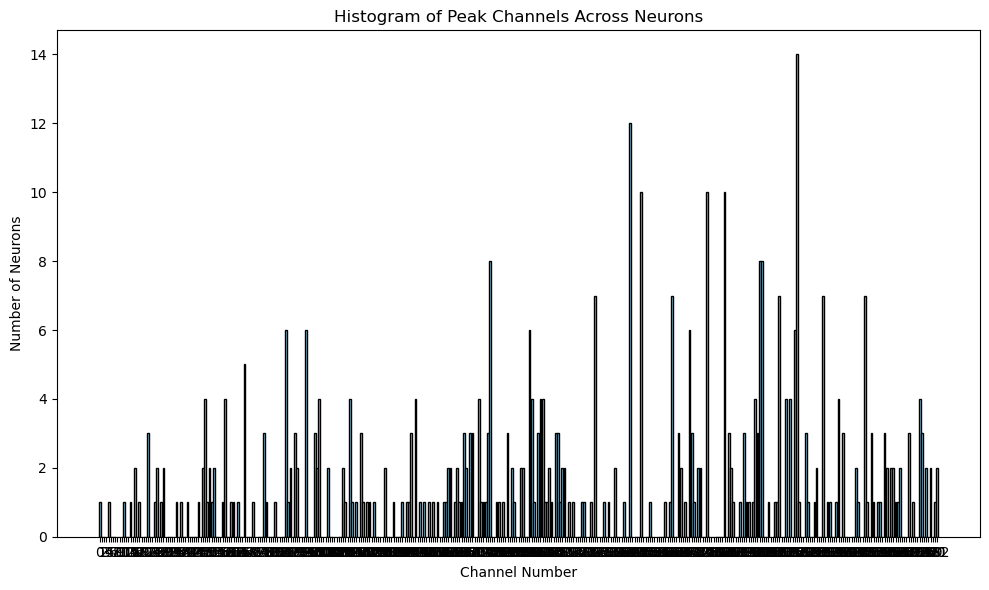

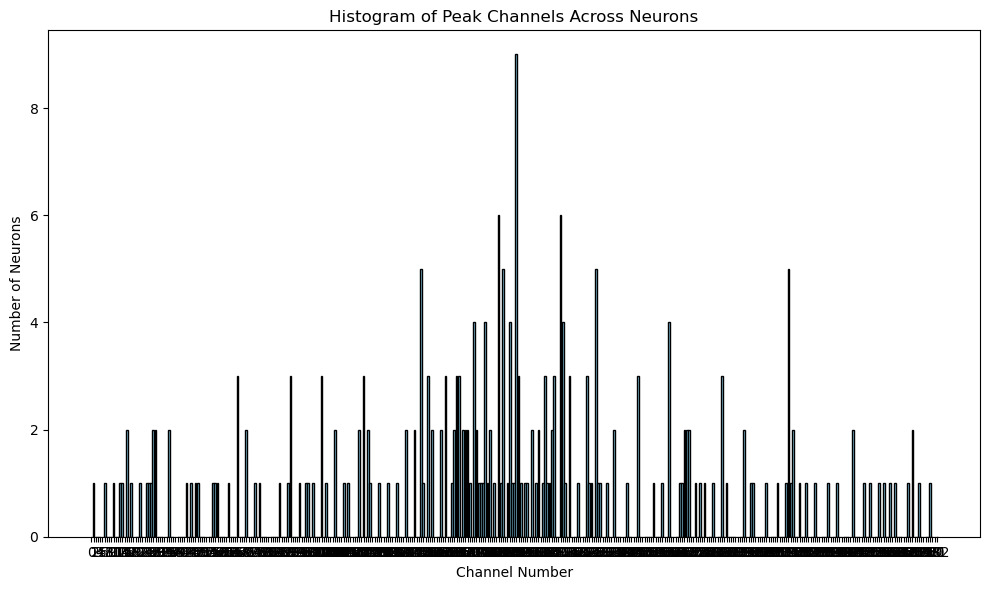

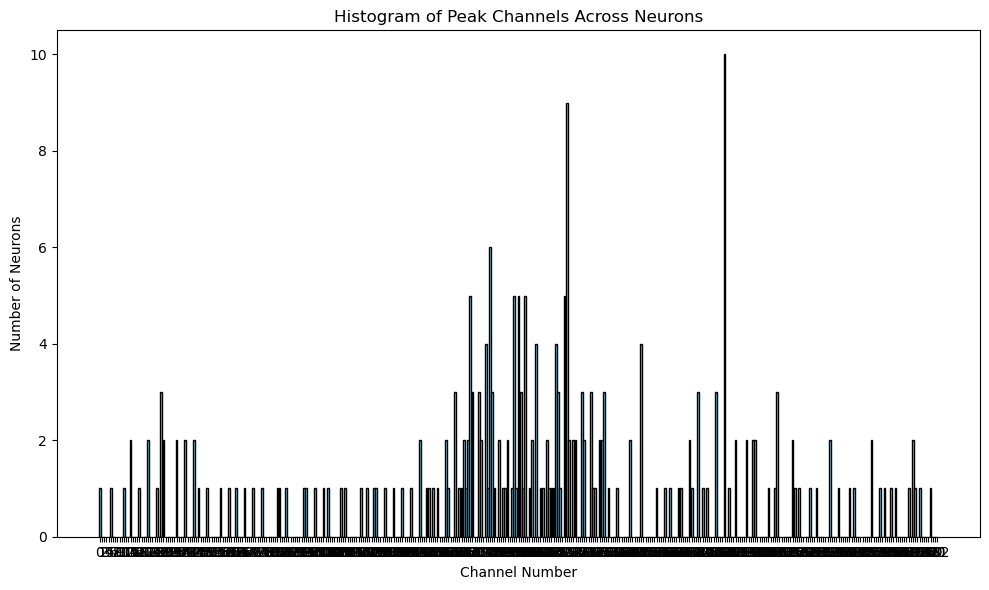

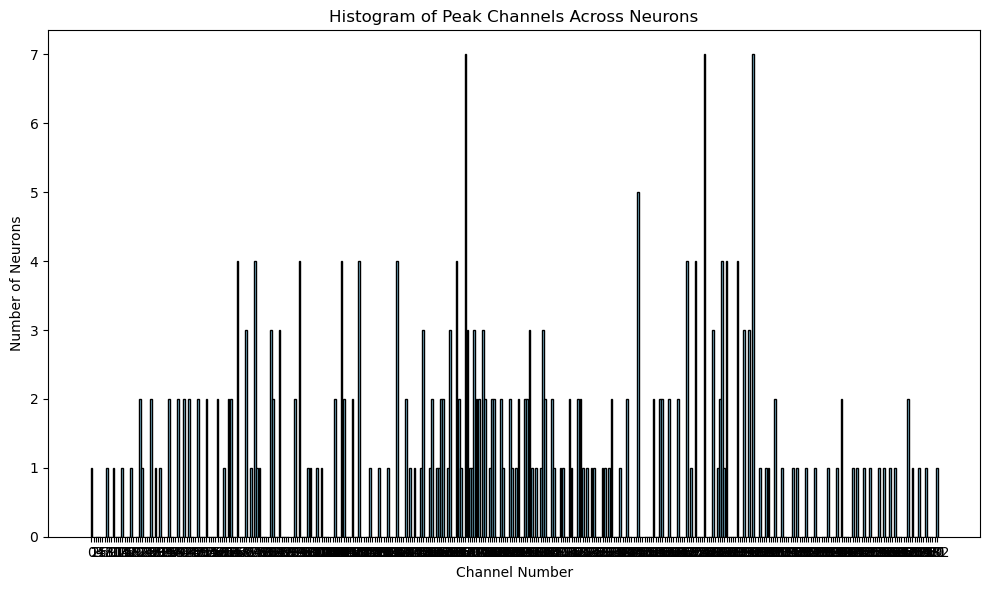

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# SETTINGS
# =============================================================================
# Path to your kilosort output file for templates (assumed to be a NumPy file)


for session in kilosort_folders:

    templates_file = os.path.join(session, 'templates.npy')
     # Expected shape: (n_templates, n_channels, n_timepoints)

    # Optional: whether to perform time-alignment so that the spike peak on the peak channel is centered
    time_align = True
    # Desired center index for alignment (if None, it will be set to the middle of the waveform)
    center_index = None  

    # =============================================================================
    # LOAD DATA
    # =============================================================================
    # Load the templates: shape (n_templates, n_channels, n_timepoints)
    templates = np.load(templates_file)
    n_templates,  n_timepoints, n_channels = templates.shape

    if center_index is None:
        center_index = n_timepoints // 2

    # =============================================================================
    # FIND PEAK CHANNEL FOR EACH NEURON
    # =============================================================================
    # For each neuron, compute the peak-to-peak amplitude per channel and identify the channel
    # with the maximum amplitude.
    peak_channels = np.empty(n_templates, dtype=int)
    for i in range(n_templates):
        template = templates[i]  # shape: (n_channels, n_timepoints)
        p2p_amplitudes = template.max(axis=0) - template.min(axis=0)
        peak_channels[i] = np.argmax(p2p_amplitudes)

    # =============================================================================
    # (OPTIONAL) TIME-ALIGN THE WAVEFORMS
    # =============================================================================
    # Shift each neuron's waveform so that the spike trough (assumed negative-going) on the peak
    # channel is centered. This makes it easier to compare waveform shapes across neurons.
    if time_align:
        aligned_templates = np.empty_like(templates)
        for i in range(n_templates):
            peak_ch = peak_channels[i]
            waveform = templates[i, :, peak_ch]
            # Identify the index of the minimum (trough) value
            peak_time_index = np.argmin(waveform)
            # Compute the shift required to bring the trough to the center_index
            shift = center_index - peak_time_index
            # Shift all channels for this neuron
            aligned_templates[i] = np.roll(templates[i], shift, axis=0)
        templates = aligned_templates

# =============================================================================
# PLOT THE WAVEFORMS FOR EACH NEURON
# =============================================================================
# Loop over each neuron and plot its waveform across all channels,
# highlighting the peak channel.
# for i in range(n_templates):
#     template = templates[i]
#     peak_ch = peak_channels[i]
#     time_axis = np.arange(n_timepoints)

#     plt.figure(figsize=(10, 6))
#     for ch in range(n_channels):
#         if ch == peak_ch:
#             plt.plot(time_axis, template[ch, :], color='red', lw=2, label=f'Channel {ch} (Peak)')
#         else:
#             plt.plot(time_axis, template[ch, :], color='gray', alpha=0.5)
#     plt.title(f'Neuron {i} Waveform (Peak Channel: {peak_ch})')
#     plt.xlabel('Time (samples)')
#     plt.ylabel('Amplitude (a.u.)')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    # Alternatively, save the figure with plt.savefig(f'neuron_{i:03d}_waveform.png')

# =============================================================================
# PLOT HISTOGRAM OF PEAK CHANNELS
# =============================================================================
# This histogram will show how many neurons have each channel as their peak channel.
# It provides insight into the spatial distribution of neural signals on the probe.
    counts = np.bincount(peak_channels, minlength=n_channels)

    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(n_channels), counts, color='skyblue', edgecolor='black')
    plt.xlabel('Channel Number')
    plt.ylabel('Number of Neurons')
    plt.title('Histogram of Peak Channels Across Neurons')
    plt.xticks(np.arange(n_channels))
    plt.tight_layout()
    plt.show()


In [7]:
templates.shape

(280, 82, 383)